## preliminary defs


In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time, os, json

from classifiers.squeezenet3 import SqueezeNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
os.system("dir>tryfile")

0

In [3]:
!type tryfile

 Volume in drive C has no label.
 Volume Serial Number is 22AD-19D4

 Directory of C:\Users\Misha\Documents\jupyter\squeezenet

02-Feb-19  04:15 PM    <DIR>          .
02-Feb-19  04:15 PM    <DIR>          ..
31-Dec-18  02:23 PM    <DIR>          .ipynb_checkpoints
15-Dec-18  04:13 PM    <DIR>          classifiers
03-Nov-18  03:25 PM    <DIR>          datasets
13-Nov-18  06:10 PM    <DIR>          example_picture
07-Oct-18  03:10 PM         5,167,371 fromSqueezeNet-v0.ipynb
23-Oct-18  05:47 PM         4,013,965 fromSqueezeNet-v2.ipynb
28-Oct-18  06:08 PM           462,312 fromSqueezeNet-v3.ipynb
15-Dec-18  04:02 PM         2,443,470 fromSqueezeNet-v4.ipynb
30-Dec-18  08:28 PM         3,481,577 fromSqueezeNet-v5-fix.ipynb
31-Dec-18  02:03 PM           269,601 fromSqueezeNet-v6.ipynb
02-Feb-19  04:15 PM         3,665,896 fromSqueezeNet-v7p1.ipynb
21-Jan-19  08:45 PM           313,712 fromSqueezeNet-v7p2.ipynb
03-Nov-18  03:17 PM               771 os.txt
11-Nov-18  10:47 PM             6,

In [2]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 22AD-19D4

 Directory of C:\Users\Misha\Documents\jupyter\squeezenet

02-Feb-19  06:55 PM    <DIR>          .
02-Feb-19  06:55 PM    <DIR>          ..
31-Dec-18  02:23 PM    <DIR>          .ipynb_checkpoints
15-Dec-18  04:13 PM    <DIR>          classifiers
07-Feb-19  04:45 PM    <DIR>          datasets
13-Nov-18  06:10 PM    <DIR>          example_picture
07-Oct-18  03:10 PM         5,167,371 fromSqueezeNet-v0.ipynb
23-Oct-18  05:47 PM         4,013,965 fromSqueezeNet-v2.ipynb
28-Oct-18  06:08 PM           462,312 fromSqueezeNet-v3.ipynb
15-Dec-18  04:02 PM         2,443,470 fromSqueezeNet-v4.ipynb
30-Dec-18  08:28 PM         3,481,577 fromSqueezeNet-v5-fix.ipynb
31-Dec-18  02:03 PM           269,601 fromSqueezeNet-v6.ipynb
02-Feb-19  06:47 PM         3,379,604 fromSqueezeNet-v7p1.ipynb
02-Feb-19  06:55 PM           375,365 fromSqueezeNet-v7p2.ipynb
02-Feb-19  06:12 PM        97,804,616 noflip160_test.tfrec
02-Feb-19  06:11 PM 

In [5]:
!dir datasets

 Volume in drive C has no label.
 Volume Serial Number is 22AD-19D4

 Directory of C:\Users\Misha\Documents\jupyter\squeezenet\datasets

03-Nov-18  03:25 PM    <DIR>          .
03-Nov-18  03:25 PM    <DIR>          ..
03-Nov-18  03:23 PM    <DIR>          squeezenet.ckpt
03-May-17  10:57 PM         4,941,984 squeezenet.ckpt.data-00000-of-00001
03-May-17  10:57 PM             2,293 squeezenet.ckpt.index
03-May-17  10:57 PM         5,060,877 squeezenet.ckpt.meta
04-Nov-18  02:05 PM    <DIR>          testpic_set1
               3 File(s)     10,005,154 bytes
               4 Dir(s)  312,988,839,936 bytes free


In [6]:
!dir datasets\testpic_set1\*csv

 Volume in drive C has no label.
 Volume Serial Number is 22AD-19D4

 Directory of C:\Users\Misha\Documents\jupyter\squeezenet\datasets\testpic_set1

04-Nov-18  02:06 PM            28,410 angles.csv
28-Oct-18  07:07 PM            66,210 angles_orig.csv
               2 File(s)         94,620 bytes
               0 Dir(s)  312,988,790,784 bytes free


# Part 1: from Pictures to Features

## Pretrained Model

#### Implementation notes 


We start with a convolutional neural network pretrained to perform image classification on ImageNet. We will use SqueezeNet [1], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

Original architecture: 
<br>input image: 224x224x3 
<br>model.layers[0]
<br>      : 111x111x64 -conv stride2 
<br>m.l[1]: 111x111x64 -relu   **(E)**
<br>m.l[2]: 55x55x64   -maxpool
<br> m.squeezed_layers[0]:
<br>                    55x55x16
<br>m.l[3]: 55x55x128  -fire
<br> m.sql[1]:           55x55x16 **(D)**
<br>m.l[4]: 55x55x128  -fire
<br>m.l[5]: 27x27x128  -maxpool
<br> m.sql[2]:           27x27x32
<br>m.l[6]: 27x27x256  -fire
<br> m.sql[3]:           27x27x32 **(C)**
<br>m.l[7]: 27x27x256  -fire
<br>m.l[8]: 13x13x256  -maxpool
<br> m.sql[4]:           13x13x48
<br>m.l[9]: 13x13x384  -fire
<br> m.sql[5]:           13x13x48
<br>m.l[10]:13x13x384  -fire
<br> m.sql[6]:           13x13x64
<br>m.l[11]:13x13x512  -fire
<br> m.sql[7]:           13x13x64  **(B)**
<br>m.l[12]:13x13x512  -fire  = model.features **(A)**
<br>m.l[13]: 13x13x512 -same as [12], saved twice in layers
<br>m.l[14]: 13x13x1000 -conv
<br>m.l[15]: 13x13x1000 -relu
<br>m.l[16]: 1x1x1000   -avgpool
<br>classifier: x1000   -reshape


#### Load the model:


##### If necessary, reset tensorflow graph
Note: this will remove from memory any models that have been loaded!!!

In [3]:
tf.reset_default_graph()
sess = get_session()

##### Load the model:

In [4]:
from classifiers.squeezenet3 import SqueezeNet

In [5]:

SAVE_PATH = 'datasets/squeezenet.ckpt'
if not os.path.exists(SAVE_PATH):
    raise ValueError("You need to download SqueezeNet!")
model = SqueezeNet(save_path=SAVE_PATH, sess=sess)

Instructions for updating:
Please use tf.global_variables instead.
INFO:tensorflow:Restoring parameters from datasets/squeezenet.ckpt
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



#### amount of data in different layers:

In [312]:
"in:", 224*224*3, ", E:", 111*111*64, ", D:", 55*55*16,", .. B:", 13*13*64, ", A:",13*13*512

('in:', 150528, ', E:', 788544, ', D:', 48400, ', .. B:', 10816, ', A:', 86528)

#### Evaluate number of weights for various architectures:

In [299]:
# original idea: use the final features layer A assisted by other layers B, C, D, E

WN= (64*6 , 9*4*6 , 6*4 , 20*4 , 9*4*6 , 36*8 , 9*8*8, 72*12, 524*12,  13*13*6, 6*6, 3*60 )
print(WN)
print(np.sum(WN))

(384, 216, 24, 80, 216, 288, 576, 864, 6288, 1014, 36, 180)
10166


In [302]:
# do not use the 512-feature layer, use B,C, D, E:

print(" using more channels (32=24+8 after merging B with f(CDE) :")
WN= (64*6 , 9*4*6 , 6*4 , 20*4 , 9*4*6 , 36*8 , 9*8*8,     72*32,  24*24, 9*8*8, 32*12,  13*13*6, 6*6, 3*60 )
print(WN)
print(np.sum(WN))

print(" using fewer channels (18=18[including 8] ):")
WN= (64*6 , 9*4*6 , 6*4 , 20*4 , 9*4*6 , 36*8 , 9*8*8,     72*18,  18*18, 9*8*6, 24*12,  13*13*6, 6*6, 3*60 )
print(WN)
print(np.sum(WN))

 using more channels (32=24+8 after merging B with f(CDE) :
(384, 216, 24, 80, 216, 288, 576, 2304, 576, 576, 384, 1014, 36, 180)
6854
 using fewer channels (18=18[including 8] ):
(384, 216, 24, 80, 216, 288, 576, 1296, 324, 432, 288, 1014, 36, 180)
5354


In [303]:
# use just the 13-channel layer B (just before the features layer):

print(" using more channels (32=24+8 after  B :")
WN= (64*32,  24*24, 9*8*8, 32*12,  13*13*6, 6*6, 3*60 )
print(WN)
print(np.sum(WN))

print(" using fewer channels (18=18[including 8] ):")
WN= (64*18,  18*18, 9*8*6, 24*12,  13*13*6, 6*6, 3*60 )
print(WN)
print(np.sum(WN))

 using more channels (32=24+8 after  B :
(2048, 576, 576, 384, 1014, 36, 180)
4814
 using fewer channels (18=18[including 8] ):
(1152, 324, 432, 288, 1014, 36, 180)
3426


## Load custom images, decode reference images

#### Function definitions:

In [6]:
from PIL import Image
import glob

import matplotlib.image as mpimg
import csv, os


In [7]:
def read_in_list(data_dirname=".",input_csv_name = "angles.csv"):
    import csv, os
    in_list = []
    with open( os.path.join(data_dirname, input_csv_name), "r") as flist:
        reader = csv.reader(flist)
        for row in reader:
            in_list.append(row)
    return in_list

In [8]:
def truncate_inputpaths(data_dirname, nsymb=43):
    #original csv file may include path that may be no longer valid
    #to use, first rename the csv file
    with open( os.path.join(data_dirname, "angles_orig.csv"), "r") as flist:
        with open( os.path.join(data_dirname, "angles.csv"), "w") as flist1:
            for l in flist:
                flist1.write(l[nsymb:])

In [9]:
#def findRaG(inputImage):
def find_root_and_end(inputImage):
    '''returns ((rooty,rootx),(endy,endx), rootFound,endFound )
    Note that y is before x (same order as the indices in the image: H,W,color)'''
    correctlocationr = inputImage[:,:,0]
    correctlocationg = inputImage[:,:,1]
    locationg = np.argmax(correctlocationg)
    locationr = np.argmax(correctlocationr)
    #
    root = np.unravel_index( locationg, inputImage.shape[:2])
    end = np.unravel_index( locationr, inputImage.shape[:2])
    #
    #sanity checks: does the pixels look compromised?
    rootpix=inputImage[root] # should be g
    endpix=inputImage[end]  # should be r
    rootFound = ( (rootpix[1]>120) and (rootpix[0]<70 ) and (rootpix[2]<70)  )
                  #and (rootpix[1] > np.linalg.norm([rootpix[0],rootpix[2]]) )     )
    endFound =  ( (endpix[0]>120) and (endpix[1]<70 ) and (endpix[2]<70)    )
                  #and (endpix[0] > np.linalg.norm([endpix[1],endpix[2]]) )       )
    #
    return (root,end,rootFound,endFound)

In [10]:
def read_files( data_dirname ):
    '''create three arrays'''
    in_list = read_in_list( data_dirname)
    my_Xraw = []
    my_Xref = []
    for line in in_list:
        im_name = os.path.join( data_dirname, line[0] )
        # should not resize yet (or else the reference image can become too blury)
        im = Image.open(im_name + "_raw.png")#.resize( (224,224) )
        im = im.convert("RGB") #otherwise there is an additional "transparency" channel
        my_Xraw.append( np.array(im) )
        im = Image.open(im_name + "_ref-tailend.png")#.resize( (224,224) )
        im = im.convert("RGB") #otherwise there is an additional "transparency" channel
        my_Xref.append( np.array(im) )

    return in_list, my_Xraw, my_Xref

In [11]:
truncate_inputpaths("datasets\\testpic7", nsymb=42)

In [25]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 22AD-19D4

 Directory of C:\Users\Misha\Documents\jupyter\squeezenet

02-Feb-19  04:17 PM    <DIR>          .
02-Feb-19  04:17 PM    <DIR>          ..
31-Dec-18  02:23 PM    <DIR>          .ipynb_checkpoints
15-Dec-18  04:13 PM    <DIR>          classifiers
03-Nov-18  03:25 PM    <DIR>          datasets
13-Nov-18  06:10 PM    <DIR>          example_picture
07-Oct-18  03:10 PM         5,167,371 fromSqueezeNet-v0.ipynb
23-Oct-18  05:47 PM         4,013,965 fromSqueezeNet-v2.ipynb
28-Oct-18  06:08 PM           462,312 fromSqueezeNet-v3.ipynb
15-Dec-18  04:02 PM         2,443,470 fromSqueezeNet-v4.ipynb
30-Dec-18  08:28 PM         3,481,577 fromSqueezeNet-v5-fix.ipynb
31-Dec-18  02:03 PM           269,601 fromSqueezeNet-v6.ipynb
02-Feb-19  04:17 PM         3,231,404 fromSqueezeNet-v7p1.ipynb
21-Jan-19  08:45 PM           313,712 fromSqueezeNet-v7p2.ipynb
03-Nov-18  03:17 PM               771 os.txt
11-Nov-18  10:47 PM             6,

#### Load data and check for issues:

In [12]:
in_list, my_Xraw, my_Xref = read_files( "datasets/testpic7" )

['pic_5_4_4', '0.05', '0.0']
((120, 139), (114, 145), True, False)
49 [  1 242  54] [103  15  62]


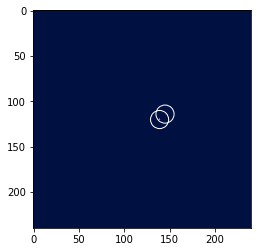

['pic_65_4_7', '0.05', '0.30000000000000004']
((137, 160), (132, 138), True, False)
590 [  1 172  59] [101  15  62]


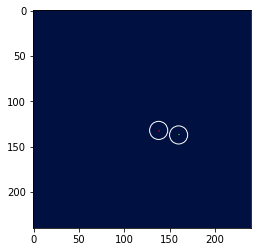

In [28]:
# confirm there are no problems -should run silently:
for i,im in enumerate(my_Xref): 
    ref=find_root_and_end(im)
    if not np.all(ref[2:]):
        print("WARNING: some reference points cannot be resolved!")
        print(in_list[i])
        print(ref)
        ax=plt.gca()
        ax.imshow(im)
        ax.add_artist(plt.Circle(ref[0][::-1], 10, color='w', fill=False))
        ax.add_artist(plt.Circle(ref[1][::-1], 10, color='w', fill=False))
        print(i, im[ref[0]], im[ref[1]])
        plt.show()
        #im1=Image.fromarray(im)
        #display(im1)
        #break

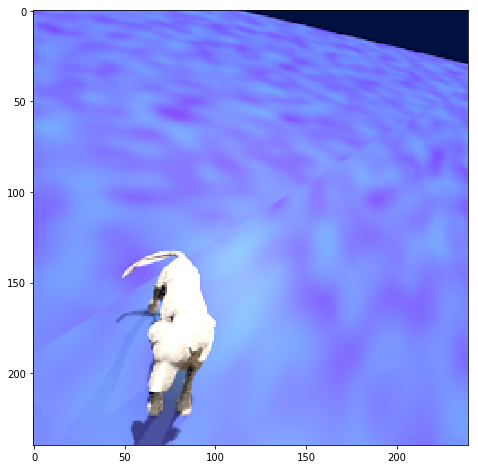

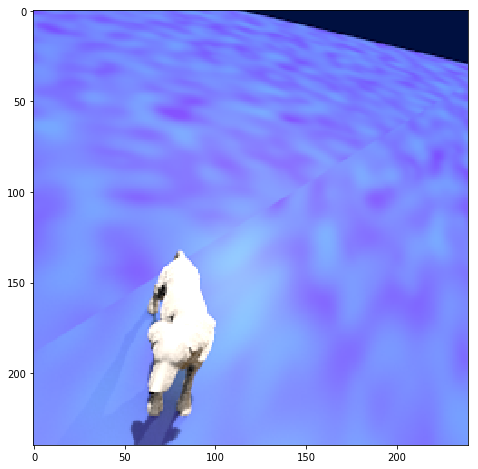

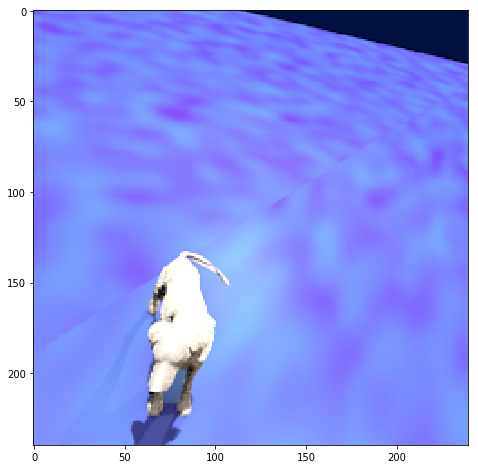

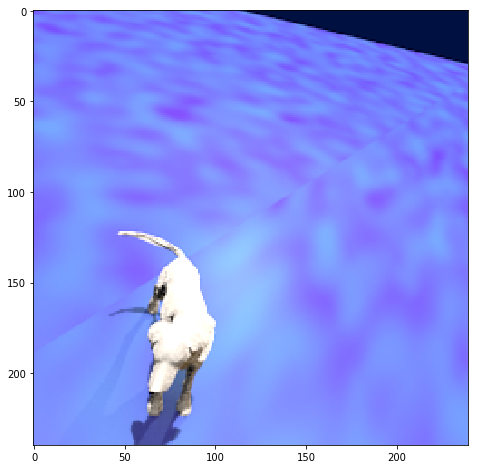

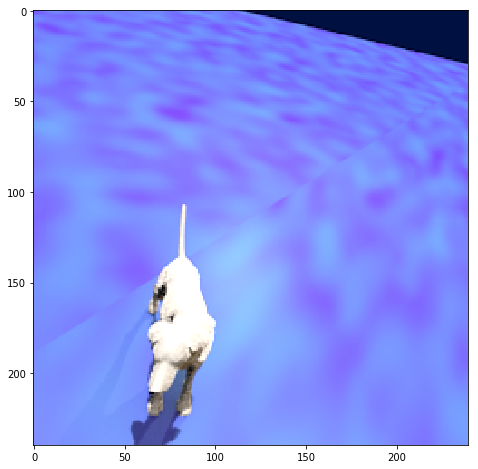

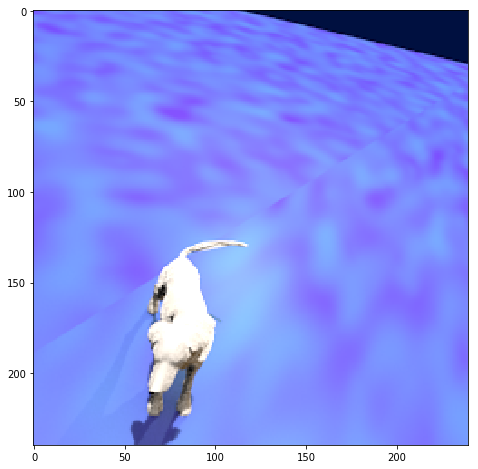

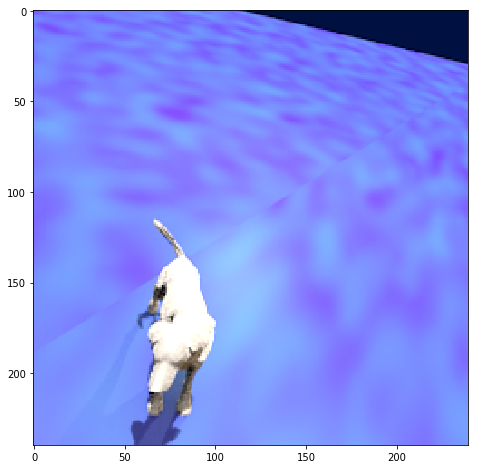

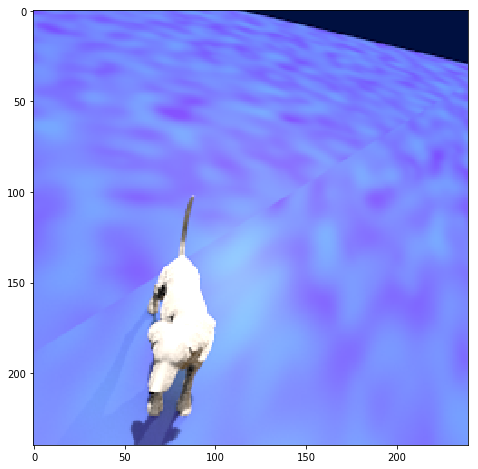

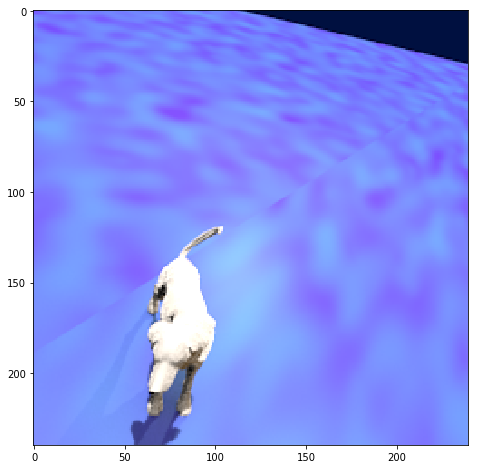

In [13]:
for i in range(9):
    plt.imshow(my_Xraw[i])
    plt.show()

0 :


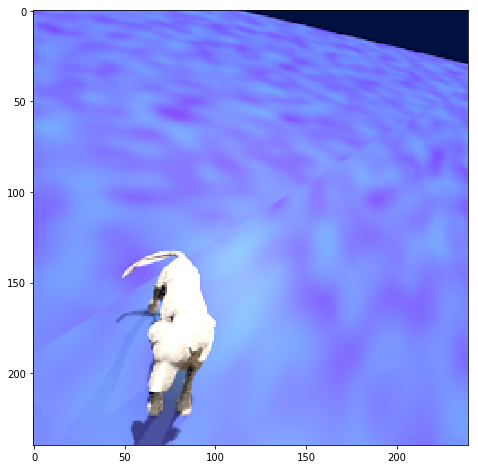

9 :


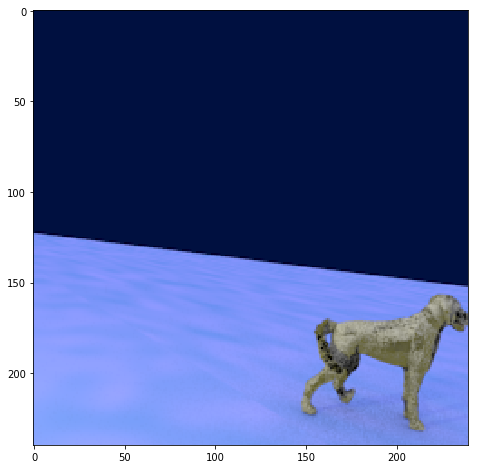

18 :


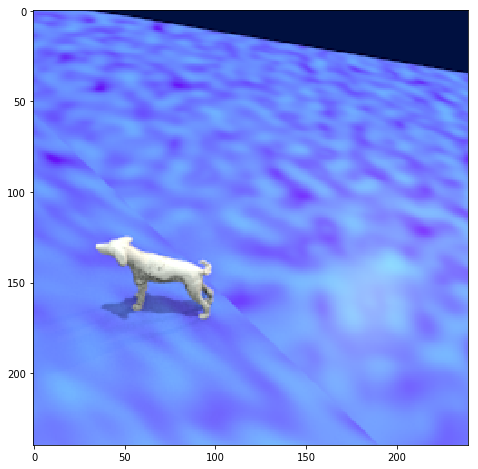

27 :


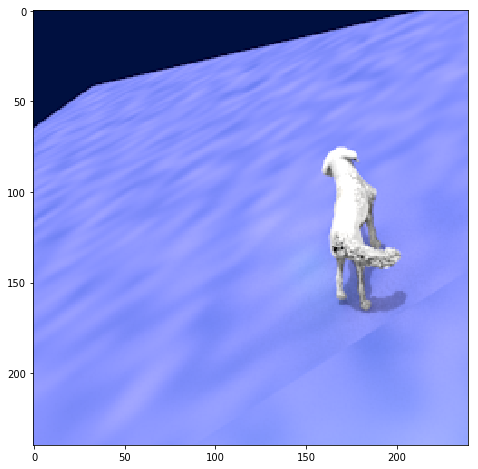

36 :


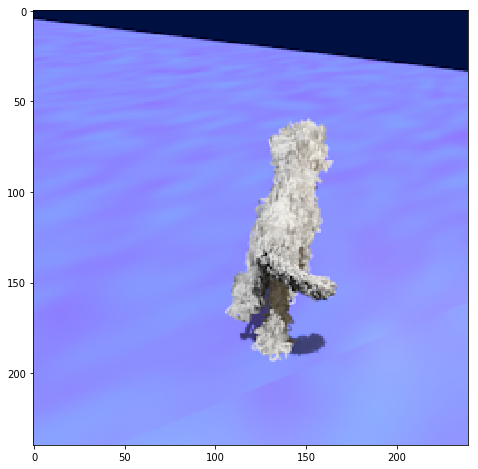

45 :


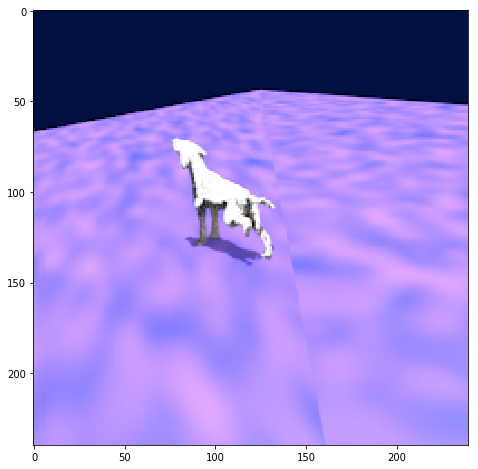

54 :


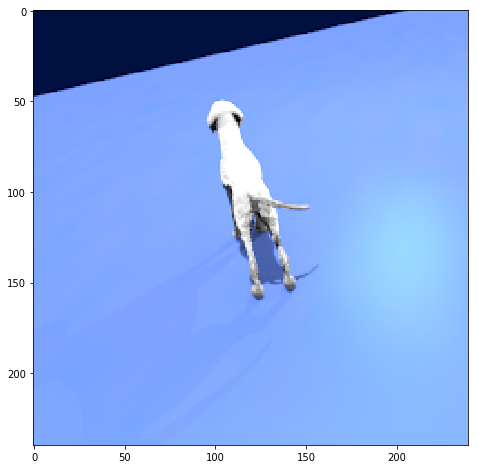

63 :


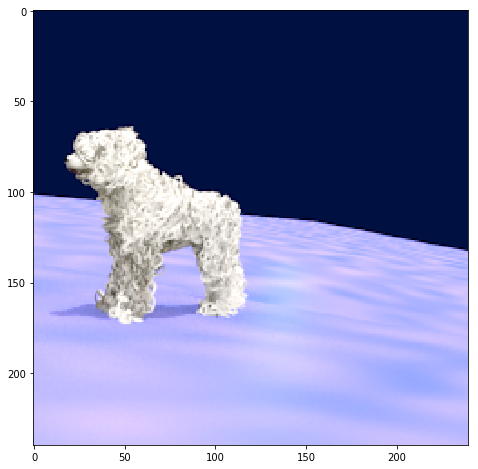

72 :


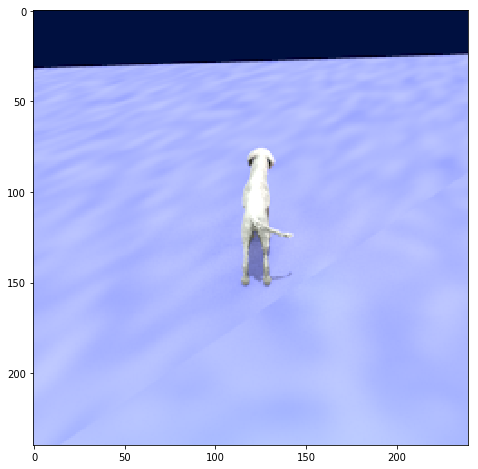

81 :


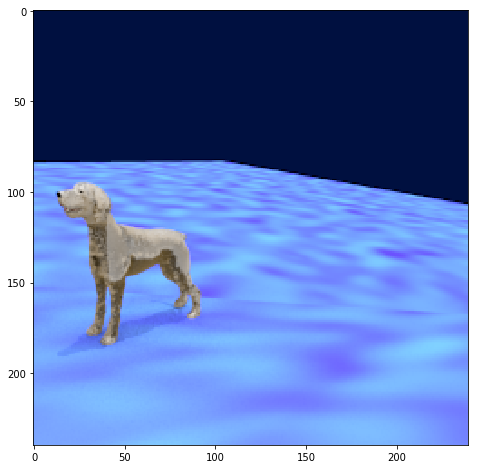

In [81]:
for i in range(0,90,9):
    print(i,":")
    plt.imshow(my_Xraw[i])
    plt.show()

## Preprocess images - generate X and Y

#### SqueezeNet-specific functions 
(to normalize image and to convert from normalized back to "usual" image):

In [13]:
SQUEEZENET_HW = 224
SQUEEZENET_SHAPE = (SQUEEZENET_HW,SQUEEZENET_HW)
#Sqeezenet-specific "mean" and "std"
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype = np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype = np.float32)

def preprocess_image(im):
    return (  im.astype(np.float32) / 255.0 - SQUEEZENET_MEAN ) / SQUEEZENET_STD

def deprocess_image(im, rescale=False):
    im = ( im * SQUEEZENET_STD + SQUEEZENET_MEAN )
    if rescale:
        vmin,vmax = im.min(), im.max()
        im = (img - vmin) / (vmax - vmin)
    im = np.clip(255 * im, 0, 255)
    return im.astype(np.uint8)


#### Functions to process input dataset  
crop,scale, normalize, determine coordinates from red/green points, and finally create X and Y

In [14]:

import itertools

def generate_variants( imdata_list, debugN=None, mini=0, maxi=30000 ):
    '''imdata_list is the image's np array and one or more reference images (e.g. with root/end markers)'''
    sets = []
    i=0
    # loop over croppings:
    for (dx0,dx1,dy0,dy1) in itertools.product([0,5,9,16], repeat=4):
        #loop over flips:
        for flipLRdir in [1,-1]:
            #TODO: loop over colors -- will need more than just array operations, 
            # e.g. would need to create Image.Image(im) and change it:
            if 1:
                #TODO: loop over intensities
                if i>=mini and i<maxi:
                    thislist = []
                    for j in range(len(imdata_list)):
                        im = imdata_list[j]
                        #print("debug:", (dy0,dy1,dx0,dx1), str( (dy0,(-dy1 or None), dx0,(-dx1 or None)) ) , type(im), j )
                        im = im[ dy0:(-dy1 or None), dx0:(-dx1 or None) ] # need None in case dy1==0
                        #print("debug: ok")
                        im = im[ :, ::flipLRdir ]
                        thislist.append( im )
                        
                    sets.append(thislist)
                    
                    if debugN is not None:
                        if len(sets)>=debugN:
                            return sets    
                i+=1
                    
    return sets
    

In [15]:

import itertools

def generate_variants_1( imdata_list, debugN=None, mini=0, maxi=30000 ):
    '''imdata_list is the image's np array and one or more reference images (e.g. with root/end markers)'''
    sets = []
    i=0
    # loop over croppings:
    for (dx0,dx1,dy0,dy1) in itertools.product([0,5,9,16], repeat=4):
        #loop over flips:
        for flipLRdir in [1,-1]:
            #TODO: loop over colors -- will need more than just array operations, 
            # e.g. would need to create Image.Image(im) and change it:
            if 1:
                #TODO: loop over intensities
                if i>=mini and i<maxi:
                    thislist = []
                    for j in range(len(imdata_list)):
                        im = imdata_list[j]
                        #print("debug:", (dy0,dy1,dx0,dx1), str( (dy0,(-dy1 or None), dx0,(-dx1 or None)) ) , type(im), j )
                        im = im[ dy0:(-dy1 or None), dx0:(-dx1 or None) ] # need None in case dy1==0
                        #print("debug: ok")
                        im = im[ :, ::flipLRdir ]
                        
                        thislist.append(im )
                        
                    sets.append((thislist,flipLRdir))
                    
                    if debugN is not None:
                        if len(sets)>=debugN:
                            return sets    
                i+=1
                    
    return sets
    

In [16]:

import itertools

def generate_variants_2( imdata_list, debugN=None, mini=0, maxi=30000 ):
    '''imdata_list is the image's np array and one or more reference images (e.g. with root/end markers)'''
    sets = []
    i=0
    # loop over croppings:
    for (dx0,dx1,dy0,dy1) in itertools.product([0,5,9,16], repeat=4):
        #loop over flips:
        for flipLRdir in [1,-1]:
            #TODO: loop over colors -- will need more than just array operations, 
            # e.g. would need to create Image.Image(im) and change it:
            if 1:
                #TODO: loop over intensities
                if i>=mini and i<maxi:
                    thislist = []
                    for j in range(len(imdata_list)):
                        throwaway=np.random.random()
                        if (throwaway<=.02):
                            im = imdata_list[j]
                            #print("debug:", (dy0,dy1,dx0,dx1), str( (dy0,(-dy1 or None), dx0,(-dx1 or None)) ) , type(im), j )
                            im = im[ dy0:(-dy1 or None), dx0:(-dx1 or None) ] # need None in case dy1==0
                            #print("debug: ok")
                            im = im[ :, ::flipLRdir ]

                            thislist.append(im )
                    if (throwaway<=.02):    
                        sets.append((thislist,flipLRdir))
                    
                    if debugN is not None:
                        if len(sets)>=debugN:
                            return sets    
                i+=1
                    
    return sets
    

Newest to oldest variants

In [17]:
# change the function below if a different validation is needed (e.g. based on what's visible)
#

def validate_image(ref_root_end):
    return np.all(ref_root_end[2:])

def generate_XandY_for_single_elem_prob( elem_inlist, elem_Xraw, elem_Xref,  debugN =None, mini=0, maxi=30000, keep_prbblty=.02 ):
    X=[]
    Y=[]
    
    for var, flip in generate_variants_1([elem_Xraw,elem_Xref], debugN, mini, maxi):
        throwaway=np.random.random()
        if (throwaway<=keep_prbblty):
            # may need to change the lines below if validate_image argument list has changed
            ref_root_end = find_root_and_end(var[1])
            if validate_image(ref_root_end):
                
                # resize original image:
                im = Image.fromarray(var[0]).resize( SQUEEZENET_SHAPE )#.convert("RGB")
                # correspondingly scale the root/end coordinates 
                # (instead, could've got them from reshaped var[1], but reshaping blurs the reference points):
                root = np.array(ref_root_end[0], dtype='float') / var[0].shape[:2] * SQUEEZENET_SHAPE
                end = np.array(ref_root_end[1], dtype='float') / var[0].shape[:2] * SQUEEZENET_SHAPE
                
                # normalize image for squeezenet:
                im = preprocess_image( np.array(im) )
                
                X.append(im)
                if (flip==1):
                    Y.append( np.array([ (float(elem_inlist[1]), float(elem_inlist[2]) ), root, end ]).flatten() )
                if (flip==-1):
                    Y.append( np.array([ (float(elem_inlist[1]), -float(elem_inlist[2]) ), root, end ]).flatten() )
    return X,Y

def generate_XandY_prob(inlist,Xraw,Xref,  debugN =None):
    assert(len(Xref)==len(Xraw) and len(Xref)==len(inlist))
    X=[]
    Y=[]
    for i in range(len(Xref)): 
        XX,YY=generate_XandY_for_single_elem_prob(inlist[i],Xraw[i],Xref[i], debugN)
        X.extend(XX)
        Y.extend(YY)
        if debugN is not None:
            if len(X)>=debugN:
                break   
    return X,Y



###### old

In [19]:
# change the function below if a different validation is needed (e.g. based on what's visible)
#

def validate_image(ref_root_end):
    return np.all(ref_root_end[2:])

def generate_XandY_for_single_elem( elem_inlist, elem_Xraw, elem_Xref,  debugN =None, mini=0, maxi=30000 ):
    X=[]
    Y=[]
    for var, flip in generate_variants_1([elem_Xraw,elem_Xref], debugN, mini, maxi):
            # may need to change the lines below if validate_image argument list has changed
            ref_root_end = find_root_and_end(var[1])
            if validate_image(ref_root_end):
                
                # resize original image:
                im = Image.fromarray(var[0]).resize( SQUEEZENET_SHAPE )#.convert("RGB")
                # correspondingly scale the root/end coordinates 
                # (instead, could've got them from reshaped var[1], but reshaping blurs the reference points):
                root = np.array(ref_root_end[0], dtype='float') / var[0].shape[:2] * SQUEEZENET_SHAPE
                end = np.array(ref_root_end[1], dtype='float') / var[0].shape[:2] * SQUEEZENET_SHAPE
                
                # normalize image for squeezenet:
                im = preprocess_image( np.array(im) )
                
                X.append(im)
                if (flip==1):
                    Y.append( np.array([ (float(elem_inlist[1]), float(elem_inlist[2]) ), root, end ]).flatten() )
                if (flip==-1):
                    Y.append( np.array([ (float(elem_inlist[1]), -float(elem_inlist[2]) ), root, end ]).flatten() )
    return X,Y

def generate_XandY(inlist,Xraw,Xref,  debugN =None):
    assert(len(Xref)==len(Xraw) and len(Xref)==len(inlist))
    X=[]
    Y=[]
    for i in range(len(Xref)): 
        XX,YY=generate_XandY_for_single_elem(inlist[i],Xraw[i],Xref[i], debugN)
        X.extend(XX)
        Y.extend(YY)
        if debugN is not None:
            if len(X)>=debugN:
                break   
    return X,Y



In [14]:
# change the function below if a different validation is needed (e.g. based on what's visible)
#

def validate_image(ref_root_end):
    return np.all(ref_root_end[2:])

def generate_XandY_for_single_elem_old( elem_inlist, elem_Xraw, elem_Xref,  debugN =None, mini=0, maxi=30000 ):
    X=[]
    Y=[]
    for var in generate_variants([elem_Xraw,elem_Xref], debugN, mini, maxi):
            # may need to change the lines below if validate_image argument list has changed
            ref_root_end = find_root_and_end(var[1])
            if validate_image(ref_root_end):
                
                # resize original image:
                im = Image.fromarray(var[0]).resize( SQUEEZENET_SHAPE )#.convert("RGB")
                # correspondingly scale the root/end coordinates 
                # (instead, could've got them from reshaped var[1], but reshaping blurs the reference points):
                root = np.array(ref_root_end[0], dtype='float') / var[0].shape[:2] * SQUEEZENET_SHAPE
                end = np.array(ref_root_end[1], dtype='float') / var[0].shape[:2] * SQUEEZENET_SHAPE
                
                # normalize image for squeezenet:
                im = preprocess_image( np.array(im) )
                
                X.append(im)
                Y.append( np.array([ (float(elem_inlist[1]), float(elem_inlist[2]) ), root, end ]).flatten() )
               
    return X,Y

def generate_XandY(inlist,Xraw,Xref,  debugN =None):
    assert(len(Xref)==len(Xraw) and len(Xref)==len(inlist))
    X=[]
    Y=[]
    for i in range(len(Xref)): 
        XX,YY=generate_XandY_for_single_elem(inlist[i],Xraw[i],Xref[i], debugN)
        X.extend(XX)
        Y.extend(YY)
        if debugN is not None:
            if len(X)>=debugN:
                break   
    return X,Y


#### debug/test

In [29]:
myX_old,myY_old=generate_XandY_for_single_elem_old(in_list[2], my_Xraw[2], my_Xref[2],None,100,200)

In [77]:
myX_old0,myY_old0=generate_XandY_for_single_elem_old(in_list[0], my_Xraw[0], my_Xref[0],None,100,200)

In [30]:
myX0,myY0=generate_XandY_for_single_elem(in_list[0], my_Xraw[0], my_Xref[0],None,100,200)

In [22]:
myX,myY=generate_XandY_for_single_elem(in_list[2], my_Xraw[2], my_Xref[2],None,100,200)

In [31]:
myX,myY=generate_XandY_for_single_elem_prob(in_list[2], my_Xraw[2], my_Xref[2],None,100,200)

In [54]:
len(myX)

100

In [200]:
myX[0].shape

(224, 224, 3)

#### Function to visualize X and Y 
takes an element of X (normalized picture) and an element of Y (6-tuple with coordinates) 
shows the picture and draws circles at specified coordinates

In [16]:
def visualize_XiYi(Xelem,Yelem):
        ax=plt.gca()
        ax.imshow(deprocess_image(Xelem))
        ax.add_artist(plt.Circle((Yelem[3],Yelem[2]), 10, color='w', fill=False))
        ax.add_artist(plt.Circle((Yelem[5],Yelem[4]), 10, color='w', fill=False))
        plt.show()

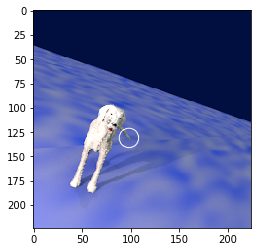

[-1.00000000e-01  3.00000000e-01  1.07636364e+02  7.70000000e+01
  1.30909091e+02  9.80000000e+01]


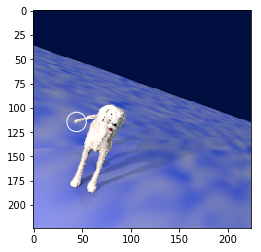

[-1.00000000e-01 -3.00000000e-01  1.07636364e+02  7.70000000e+01
  1.14424242e+02  4.40000000e+01]


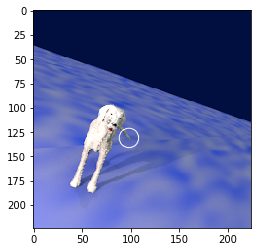

[-1.00000000e-01  3.00000000e-01  1.07636364e+02  7.70000000e+01
  1.30909091e+02  9.80000000e+01]


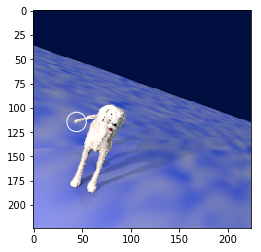

[-1.00000000e-01 -3.00000000e-01  1.07636364e+02  7.70000000e+01
  1.14424242e+02  4.40000000e+01]


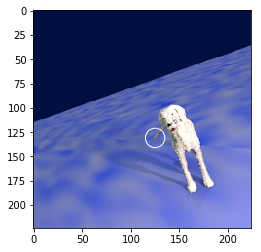

[-1.00000000e-01 -3.00000000e-01  1.07636364e+02  1.46000000e+02
  1.30909091e+02  1.25000000e+02]


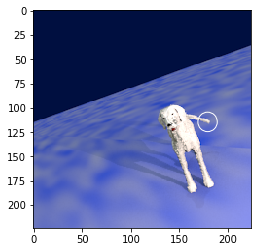

[-1.00000000e-01  3.00000000e-01  1.07636364e+02  1.46000000e+02
  1.14424242e+02  1.79000000e+02]


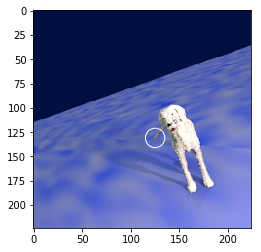

[-1.00000000e-01  3.00000000e-01  1.07636364e+02  1.46000000e+02
  1.30909091e+02  1.25000000e+02]


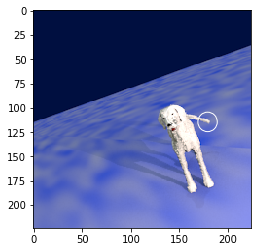

[-1.00000000e-01 -3.00000000e-01  1.07636364e+02  1.46000000e+02
  1.14424242e+02  1.79000000e+02]


In [82]:
for i in range(0,2):
        visualize_XiYi(myX[i],myY[i])
        print(myY[i])
        visualize_XiYi(myX0[i],myY0[i])
        print(myY0[i])
        visualize_XiYi(myX_old[i],myY_old[i])
        print(myY_old[i])
        visualize_XiYi(myX_old0[i],myY_old0[i])
        print(myY_old0[i])

In [64]:
myY[:100]

[array([-1.00000000e-01,  3.00000000e-01,  1.07636364e+02,  7.70000000e+01,
         1.30909091e+02,  9.80000000e+01]),
 array([-1.00000000e-01, -3.00000000e-01,  1.07636364e+02,  1.46000000e+02,
         1.30909091e+02,  1.25000000e+02]),
 array([-1.00e-01,  3.00e-01,  1.11e+02,  7.70e+01,  1.35e+02,  9.80e+01]),
 array([-1.00e-01, -3.00e-01,  1.11e+02,  1.46e+02,  1.35e+02,  1.25e+02]),
 array([-1.00000000e-01,  3.00000000e-01,  1.01038298e+02,  7.70000000e+01,
         1.23914894e+02,  9.80000000e+01]),
 array([-1.00000000e-01, -3.00000000e-01,  1.01038298e+02,  1.46000000e+02,
         1.23914894e+02,  1.25000000e+02]),
 array([-1.00000000e-01,  3.00000000e-01,  1.03234783e+02,  7.70000000e+01,
         1.26608696e+02,  9.80000000e+01]),
 array([-1.00000000e-01, -3.00000000e-01,  1.03234783e+02,  1.46000000e+02,
         1.26608696e+02,  1.25000000e+02]),
 array([-1.00000000e-01,  3.00000000e-01,  1.05061947e+02,  7.70000000e+01,
         1.28849558e+02,  9.80000000e+01]),
 array([

0 :


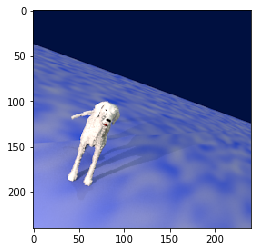

1 :


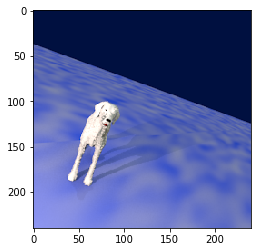

2 :


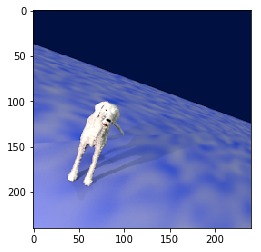

3 :


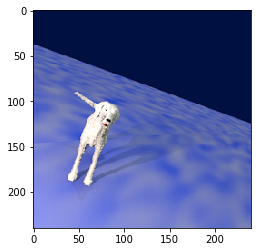

4 :


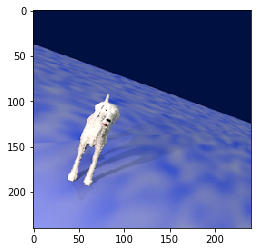

5 :


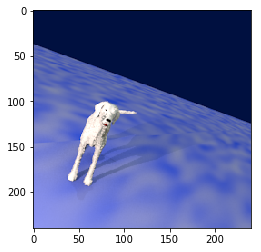

6 :


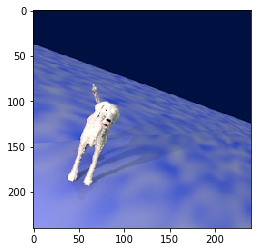

7 :


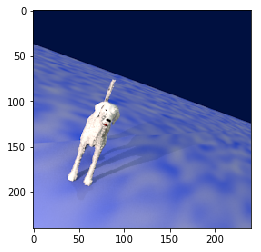

8 :


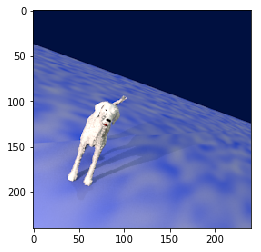

9 :


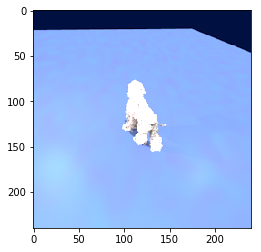

In [21]:
for i in range(0,10):
    print(i,":")
    plt.imshow(my_Xraw[i])
    plt.show()

In [27]:
in_list[:10]

[['pic_0_1_1', '-0.1', '-0.30000000000000004'],
 ['pic_0_1_4', '-0.1', '0.0'],
 ['pic_0_1_7', '-0.1', '0.30000000000000004'],
 ['pic_0_4_1', '0.05', '-0.30000000000000004'],
 ['pic_0_4_4', '0.05', '0.0'],
 ['pic_0_4_7', '0.05', '0.30000000000000004'],
 ['pic_0_7_1', '0.2', '-0.30000000000000004'],
 ['pic_0_7_4', '0.2', '0.0'],
 ['pic_0_7_7', '0.2', '0.30000000000000004'],
 ['pic_1_1_1', '-0.1', '-0.30000000000000004']]

## Compute/write features 

### In-memory function 
Not writing to file but creating dictionary<br>
**(Currently unused)**

In [18]:

def cache_layers_dict(X, model, layerN_list=[], squeezed_layerN_list=[]):
    tensors1 = { "layer_"+str(lN) : model.layers[lN]  \
                for lN in layerN_list }       
    tensors2 = { "squeezed_layer_"+str(slN) : model.squeezed_layers[slN]  \
                for slN in squeezed_layerN_list }   
    tensors = {**tensors1, **tensors2} # merge two dicts (python 3)
    
    res  = sess.run( tensors, feed_dict={model.image: X})
    return res



In [21]:
trycache1 = cache_layers_dict( myX[:5], model, [0],[1,3,7])

NameError: name 'myX' is not defined

In [ ]:
for k in trycache1:
    print( k, (trycache1[k]).shape, (trycache1[k]).dtype)

### write to file

#### Define function

In [19]:

def generate_XFeat_and_Y_TFRecord ( inlist, Xraw, Xref,  model,  layerN_list=[], squeezed_layerN_list=[],  
                                   filename="XandY.tfrec", debugN=None ):
    '''Note need to convert nparrays to a list of 1D arrays to store in TFRecord, 
    this means either the dimensions of each layer need be saved,
    or the reader should know the dimensions of each array (other than Nelements which becomes the dimension of the list) '''
    assert( len(Xref) == len(Xraw)   and   len(Xref) == len(inlist) )

    # cache_layers1:
    tensors1 = { "layer_"+str(lN) : model.layers[lN]  \
                for lN in layerN_list }       
    tensors2 = { "squeezed_layer_"+str(slN) : model.squeezed_layers[slN]  \
                for slN in squeezed_layerN_list }  
    tensors = { **tensors1, **tensors2 } # merge two dicts (python 3)
    
    Ykeys = ["angle_vert", "angle_horiz", "rooty", "rootx", "endy", "endx"]
    
    size_log={}; type_log={}

    with tf.python_io.TFRecordWriter(filename) as writer:
    
        print("debug: opened writer YYY")
        #process each record independently to minimize memory hiccups:
        for i in range(len(Xref)): 
            #print("debug: starting i=",i)
            aux_lims = range(0,30000,100) # avoid too large arrays returned by generate_XandY
            for ilim in range(1,len(aux_lims)):
                mini = aux_lims[ilim-1]
                maxi = aux_lims[ilim]
                XX,YY = generate_XandY_for_single_elem_prob(inlist[i],Xraw[i],Xref[i], debugN, mini=mini, maxi=maxi)
                
                Nelem= len(XX)
                if Nelem>0:
                    print("debug: i=",i,", maxi=", maxi, ", generated XX, Nelem=",Nelem)
                    XXFeat  = sess.run( tensors, feed_dict={model.image: XX})
                    #print("debug:        extracted XXFeat")
                    ##returns dictionary: keys - as defined in "tensors", values - nparrays with an extra dimension = Nelem
                    #if debugN is not None:
                    #    Nelem=debugN
                    #
                    for j in range(Nelem):

                        features ={}
                        for k in XXFeat:
                            ### BytesList is used for raw images (when each pixel is a single byte, i.e. dtype='uint8')
                            #features[k] = tf.train.Feature( 
                            #                        bytes_list = tf.train.BytesList( value = [ XXFeat[k][j].tostring() ] )
                            #                                )
                            ### since the layers are already floats, write them as such:
                            features[k] = tf.train.Feature( 
                                                    float_list = tf.train.FloatList( value = XXFeat[k][j] .flatten().tolist() )
                                                            )
                            #this should only be done once but instead do in the loop as the overhead is small:

                        for ik,k in enumerate(Ykeys):
                            features[k] = tf.train.Feature(
                                                    float_list = tf.train.FloatList( value = [ YY[j][ik] ] )
                                                            )
                        #if maxi>500:
                        #    print("debug:        created dict of Feature objects")
                        example = tf.train.Example( features=tf.train.Features(feature=features) )
                        writer.write(example.SerializeToString())
                        #if maxi>500:
                        #    print("debug:        completed j =",j)
                    if debugN is not None:
                        break
                #print("debug: completed ilim loop's body for i=",i, ", ilim=",ilim)
                
            #print("debug: completed i loop's body for i=",i)

        # by now XXFeat contains the data for one (the last) image - use it to remember the layer types/sizes:
        print("debug: summarizing")
        for k in XXFeat:
            size_log[k]=XXFeat[k][j].shape
            type_log[k]=XXFeat[k][j].dtype
            print(k,": ", size_log[k], type_log[k])
        # here, could write them to a separate file (name created from the same base) for future use - not implemented
                    

#### Write to file 
memorize the name and the dimensions of the written layer (see the last line of output) - those would be required when reading the file

In [94]:
generate_XFeat_and_Y_TFRecord(  in_list[:], my_Xraw[:9], my_Xref[:9],  model, [],[7], filename="XandY_9c.tfrec" )

debug: opened writer YYY
debug: i= 0 , maxi= 100 , generated XX, Nelem= 100
debug: i= 0 , maxi= 200 , generated XX, Nelem= 100
debug: i= 0 , maxi= 300 , generated XX, Nelem= 100
debug: i= 0 , maxi= 400 , generated XX, Nelem= 100
debug: i= 0 , maxi= 500 , generated XX, Nelem= 100
debug: i= 0 , maxi= 600 , generated XX, Nelem= 12
debug: i= 1 , maxi= 100 , generated XX, Nelem= 100
debug: i= 1 , maxi= 200 , generated XX, Nelem= 100
debug: i= 1 , maxi= 300 , generated XX, Nelem= 100
debug: i= 1 , maxi= 400 , generated XX, Nelem= 100
debug: i= 1 , maxi= 500 , generated XX, Nelem= 100
debug: i= 1 , maxi= 600 , generated XX, Nelem= 12
debug: i= 2 , maxi= 100 , generated XX, Nelem= 100
debug: i= 2 , maxi= 200 , generated XX, Nelem= 100
debug: i= 2 , maxi= 300 , generated XX, Nelem= 100
debug: i= 2 , maxi= 400 , generated XX, Nelem= 100
debug: i= 2 , maxi= 500 , generated XX, Nelem= 100
debug: i= 2 , maxi= 600 , generated XX, Nelem= 12
debug: i= 3 , maxi= 100 , generated XX, Nelem= 100
debug: i=

In [33]:
os.chdir("C:\\Users\\Misha\\Documents\\blender\\testpic6stable")

In [34]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 22AD-19D4

 Directory of C:\Users\Misha\Documents\blender\testpic6stable

02-Feb-19  01:12 PM    <DIR>          .
02-Feb-19  01:12 PM    <DIR>          ..
02-Feb-19  01:11 PM           121,611 angles.csv
02-Feb-19  11:08 AM            14,832 pic_0_1_1_raw.png
02-Feb-19  11:08 AM             2,128 pic_0_1_1_ref-tailend.png
02-Feb-19  11:08 AM            14,982 pic_0_1_4_raw.png
02-Feb-19  11:08 AM             2,135 pic_0_1_4_ref-tailend.png
02-Feb-19  11:09 AM            14,867 pic_0_1_7_raw.png
02-Feb-19  11:09 AM             2,166 pic_0_1_7_ref-tailend.png
02-Feb-19  11:09 AM            15,687 pic_0_4_1_raw.png
02-Feb-19  11:09 AM             2,147 pic_0_4_1_ref-tailend.png
02-Feb-19  11:09 AM            15,268 pic_0_4_4_raw.png
02-Feb-19  11:09 AM             2,150 pic_0_4_4_ref-tailend.png
02-Feb-19  11:09 AM            14,995 pic_0_4_7_raw.png
02-Feb-19  11:09 AM             2,124 pic_0_4_7_ref-tailend.png
02-Feb-19  11:09 A

02-Feb-19  11:18 AM             2,087 pic_37_1_1_ref-tailend.png
02-Feb-19  11:18 AM             6,343 pic_37_1_4_raw.png
02-Feb-19  11:18 AM             2,080 pic_37_1_4_ref-tailend.png
02-Feb-19  11:18 AM             6,446 pic_37_1_7_raw.png
02-Feb-19  11:18 AM             2,049 pic_37_1_7_ref-tailend.png
02-Feb-19  11:18 AM             6,663 pic_37_4_1_raw.png
02-Feb-19  11:18 AM             2,101 pic_37_4_1_ref-tailend.png
02-Feb-19  11:18 AM             6,521 pic_37_4_4_raw.png
02-Feb-19  11:18 AM             2,108 pic_37_4_4_ref-tailend.png
02-Feb-19  11:18 AM             6,414 pic_37_4_7_raw.png
02-Feb-19  11:18 AM             2,103 pic_37_4_7_ref-tailend.png
02-Feb-19  11:18 AM             6,826 pic_37_7_1_raw.png
02-Feb-19  11:18 AM             2,132 pic_37_7_1_ref-tailend.png
02-Feb-19  11:18 AM             6,819 pic_37_7_4_raw.png
02-Feb-19  11:18 AM             2,128 pic_37_7_4_ref-tailend.png
02-Feb-19  11:18 AM             6,532 pic_37_7_7_raw.png
02-Feb-19  11:18 AM     

In [23]:
generate_XFeat_and_Y_TFRecord(  in_list[:15], my_Xraw[:150], my_Xref[:150],  model, [],[1,3,7], filename="XBCDandY_150.tfrec" )

debug: opened writer YYY
debug: i= 0 , maxi= 100 , generated XX, Nelem= 100
debug: i= 0 , maxi= 200 , generated XX, Nelem= 100
debug: i= 0 , maxi= 300 , generated XX, Nelem= 100
debug: i= 0 , maxi= 400 , generated XX, Nelem= 100
debug: i= 0 , maxi= 500 , generated XX, Nelem= 100
debug: i= 0 , maxi= 600 , generated XX, Nelem= 12
debug: i= 1 , maxi= 100 , generated XX, Nelem= 100
debug: i= 1 , maxi= 200 , generated XX, Nelem= 100
debug: i= 1 , maxi= 300 , generated XX, Nelem= 100
debug: i= 1 , maxi= 400 , generated XX, Nelem= 100
debug: i= 1 , maxi= 500 , generated XX, Nelem= 100
debug: i= 1 , maxi= 600 , generated XX, Nelem= 12
debug: i= 2 , maxi= 100 , generated XX, Nelem= 100
debug: i= 2 , maxi= 200 , generated XX, Nelem= 100
debug: i= 2 , maxi= 300 , generated XX, Nelem= 100
debug: i= 2 , maxi= 400 , generated XX, Nelem= 100
debug: i= 2 , maxi= 500 , generated XX, Nelem= 100
debug: i= 2 , maxi= 600 , generated XX, Nelem= 12
debug: i= 3 , maxi= 100 , generated XX, Nelem= 100
debug: i=

#### verify

In [95]:
!dir *tfrec

 Volume in drive C has no label.
 Volume Serial Number is 22AD-19D4

 Directory of C:\Users\Misha\Documents\jupyter\squeezenet

04-Nov-18  03:45 PM       200,176,128 XandY_9.tfrec
04-Nov-18  03:55 PM     1,979,519,488 XandY_90.tfrec
30-Dec-18  05:15 PM       200,176,128 XandY_9c.tfrec
               3 File(s)  2,379,871,744 bytes
               0 Dir(s)  405,596,872,704 bytes free


In [29]:
file_size_per_example = 86882//2
this_file_size = 200176128
#this_file_size = 1979519488
print("total examples:", this_file_size//file_size_per_example)

total examples: 4608


In [36]:
#512*9
45568//512

89

## create val and test

In [20]:
def load_train_and_val (train=1, valid=1, test=1,  filename="default"):
    generate_XFeat_and_Y_TFRecord(  in_list[:train], my_Xraw[:train], my_Xref[:train],  model, [], [1,3,7], filename=filename+"_train.tfrec" )
    generate_XFeat_and_Y_TFRecord(  in_list[train:train+valid], my_Xraw[train:train+valid], my_Xref[train:train+valid],  model, [], [1,3,7], filename=filename+"_valid.tfrec" )
    generate_XFeat_and_Y_TFRecord(  in_list[train+valid:train+valid+test], my_Xraw[train+valid:train+valid+test], my_Xref[train+valid:train+valid+test],  model, [], [1,3,7], filename=filename+"_test.tfrec" )
    

In [21]:
load_train_and_val(600,300,100,"1000")

debug: opened writer YYY
debug: i= 0 , maxi= 100 , generated XX, Nelem= 2
debug: i= 0 , maxi= 300 , generated XX, Nelem= 5
debug: i= 0 , maxi= 400 , generated XX, Nelem= 3
debug: i= 0 , maxi= 500 , generated XX, Nelem= 2
debug: i= 1 , maxi= 100 , generated XX, Nelem= 3
debug: i= 1 , maxi= 200 , generated XX, Nelem= 2
debug: i= 1 , maxi= 300 , generated XX, Nelem= 1
debug: i= 1 , maxi= 400 , generated XX, Nelem= 1
debug: i= 1 , maxi= 500 , generated XX, Nelem= 1
debug: i= 2 , maxi= 100 , generated XX, Nelem= 3
debug: i= 2 , maxi= 200 , generated XX, Nelem= 4
debug: i= 2 , maxi= 300 , generated XX, Nelem= 1
debug: i= 2 , maxi= 400 , generated XX, Nelem= 3
debug: i= 2 , maxi= 500 , generated XX, Nelem= 1
debug: i= 3 , maxi= 100 , generated XX, Nelem= 2
debug: i= 3 , maxi= 200 , generated XX, Nelem= 5
debug: i= 3 , maxi= 300 , generated XX, Nelem= 4
debug: i= 3 , maxi= 400 , generated XX, Nelem= 3
debug: i= 3 , maxi= 500 , generated XX, Nelem= 1
debug: i= 4 , maxi= 100 , generated XX, Nele

debug: i= 36 , maxi= 300 , generated XX, Nelem= 1
debug: i= 36 , maxi= 500 , generated XX, Nelem= 4
debug: i= 37 , maxi= 100 , generated XX, Nelem= 2
debug: i= 37 , maxi= 200 , generated XX, Nelem= 3
debug: i= 37 , maxi= 300 , generated XX, Nelem= 3
debug: i= 37 , maxi= 400 , generated XX, Nelem= 3
debug: i= 37 , maxi= 600 , generated XX, Nelem= 1
debug: i= 38 , maxi= 200 , generated XX, Nelem= 5
debug: i= 38 , maxi= 300 , generated XX, Nelem= 3
debug: i= 38 , maxi= 400 , generated XX, Nelem= 2
debug: i= 38 , maxi= 500 , generated XX, Nelem= 1
debug: i= 39 , maxi= 100 , generated XX, Nelem= 2
debug: i= 39 , maxi= 200 , generated XX, Nelem= 2
debug: i= 39 , maxi= 300 , generated XX, Nelem= 3
debug: i= 39 , maxi= 400 , generated XX, Nelem= 3
debug: i= 39 , maxi= 500 , generated XX, Nelem= 5
debug: i= 39 , maxi= 600 , generated XX, Nelem= 1
debug: i= 40 , maxi= 100 , generated XX, Nelem= 4
debug: i= 40 , maxi= 200 , generated XX, Nelem= 3
debug: i= 40 , maxi= 300 , generated XX, Nelem= 1


debug: i= 71 , maxi= 500 , generated XX, Nelem= 3
debug: i= 71 , maxi= 600 , generated XX, Nelem= 1
debug: i= 72 , maxi= 100 , generated XX, Nelem= 4
debug: i= 72 , maxi= 300 , generated XX, Nelem= 2
debug: i= 72 , maxi= 400 , generated XX, Nelem= 3
debug: i= 72 , maxi= 500 , generated XX, Nelem= 2
debug: i= 73 , maxi= 100 , generated XX, Nelem= 4
debug: i= 73 , maxi= 300 , generated XX, Nelem= 4
debug: i= 73 , maxi= 400 , generated XX, Nelem= 5
debug: i= 73 , maxi= 500 , generated XX, Nelem= 2
debug: i= 74 , maxi= 100 , generated XX, Nelem= 2
debug: i= 74 , maxi= 300 , generated XX, Nelem= 1
debug: i= 74 , maxi= 400 , generated XX, Nelem= 2
debug: i= 74 , maxi= 500 , generated XX, Nelem= 5
debug: i= 75 , maxi= 100 , generated XX, Nelem= 2
debug: i= 75 , maxi= 300 , generated XX, Nelem= 1
debug: i= 75 , maxi= 400 , generated XX, Nelem= 5
debug: i= 75 , maxi= 500 , generated XX, Nelem= 2
debug: i= 76 , maxi= 100 , generated XX, Nelem= 2
debug: i= 76 , maxi= 200 , generated XX, Nelem= 3


debug: i= 108 , maxi= 200 , generated XX, Nelem= 5
debug: i= 108 , maxi= 300 , generated XX, Nelem= 3
debug: i= 108 , maxi= 400 , generated XX, Nelem= 4
debug: i= 108 , maxi= 500 , generated XX, Nelem= 1
debug: i= 109 , maxi= 100 , generated XX, Nelem= 1
debug: i= 109 , maxi= 300 , generated XX, Nelem= 1
debug: i= 110 , maxi= 100 , generated XX, Nelem= 2
debug: i= 110 , maxi= 200 , generated XX, Nelem= 2
debug: i= 110 , maxi= 400 , generated XX, Nelem= 2
debug: i= 110 , maxi= 500 , generated XX, Nelem= 5
debug: i= 111 , maxi= 100 , generated XX, Nelem= 1
debug: i= 111 , maxi= 400 , generated XX, Nelem= 3
debug: i= 111 , maxi= 600 , generated XX, Nelem= 1
debug: i= 112 , maxi= 100 , generated XX, Nelem= 4
debug: i= 112 , maxi= 200 , generated XX, Nelem= 4
debug: i= 112 , maxi= 300 , generated XX, Nelem= 3
debug: i= 112 , maxi= 400 , generated XX, Nelem= 1
debug: i= 112 , maxi= 500 , generated XX, Nelem= 1
debug: i= 113 , maxi= 100 , generated XX, Nelem= 2
debug: i= 113 , maxi= 200 , gen

debug: i= 144 , maxi= 500 , generated XX, Nelem= 1
debug: i= 145 , maxi= 100 , generated XX, Nelem= 4
debug: i= 145 , maxi= 200 , generated XX, Nelem= 2
debug: i= 145 , maxi= 400 , generated XX, Nelem= 1
debug: i= 145 , maxi= 500 , generated XX, Nelem= 4
debug: i= 145 , maxi= 600 , generated XX, Nelem= 1
debug: i= 146 , maxi= 100 , generated XX, Nelem= 2
debug: i= 146 , maxi= 200 , generated XX, Nelem= 2
debug: i= 146 , maxi= 300 , generated XX, Nelem= 3
debug: i= 146 , maxi= 500 , generated XX, Nelem= 2
debug: i= 147 , maxi= 100 , generated XX, Nelem= 2
debug: i= 147 , maxi= 200 , generated XX, Nelem= 1
debug: i= 147 , maxi= 300 , generated XX, Nelem= 3
debug: i= 147 , maxi= 400 , generated XX, Nelem= 1
debug: i= 147 , maxi= 500 , generated XX, Nelem= 2
debug: i= 148 , maxi= 100 , generated XX, Nelem= 2
debug: i= 148 , maxi= 300 , generated XX, Nelem= 2
debug: i= 148 , maxi= 400 , generated XX, Nelem= 3
debug: i= 148 , maxi= 500 , generated XX, Nelem= 1
debug: i= 149 , maxi= 100 , gen

debug: i= 181 , maxi= 100 , generated XX, Nelem= 3
debug: i= 181 , maxi= 200 , generated XX, Nelem= 3
debug: i= 181 , maxi= 300 , generated XX, Nelem= 1
debug: i= 181 , maxi= 400 , generated XX, Nelem= 1
debug: i= 181 , maxi= 500 , generated XX, Nelem= 2
debug: i= 182 , maxi= 100 , generated XX, Nelem= 2
debug: i= 182 , maxi= 200 , generated XX, Nelem= 5
debug: i= 182 , maxi= 300 , generated XX, Nelem= 1
debug: i= 182 , maxi= 400 , generated XX, Nelem= 2
debug: i= 182 , maxi= 500 , generated XX, Nelem= 2
debug: i= 183 , maxi= 100 , generated XX, Nelem= 6
debug: i= 183 , maxi= 200 , generated XX, Nelem= 2
debug: i= 183 , maxi= 300 , generated XX, Nelem= 1
debug: i= 183 , maxi= 400 , generated XX, Nelem= 2
debug: i= 183 , maxi= 500 , generated XX, Nelem= 4
debug: i= 184 , maxi= 100 , generated XX, Nelem= 6
debug: i= 184 , maxi= 200 , generated XX, Nelem= 1
debug: i= 184 , maxi= 300 , generated XX, Nelem= 2
debug: i= 184 , maxi= 400 , generated XX, Nelem= 2
debug: i= 184 , maxi= 500 , gen

debug: i= 215 , maxi= 100 , generated XX, Nelem= 2
debug: i= 215 , maxi= 300 , generated XX, Nelem= 3
debug: i= 215 , maxi= 400 , generated XX, Nelem= 3
debug: i= 215 , maxi= 500 , generated XX, Nelem= 6
debug: i= 216 , maxi= 100 , generated XX, Nelem= 3
debug: i= 216 , maxi= 200 , generated XX, Nelem= 2
debug: i= 216 , maxi= 300 , generated XX, Nelem= 1
debug: i= 216 , maxi= 400 , generated XX, Nelem= 1
debug: i= 216 , maxi= 500 , generated XX, Nelem= 1
debug: i= 216 , maxi= 600 , generated XX, Nelem= 1
debug: i= 217 , maxi= 100 , generated XX, Nelem= 3
debug: i= 217 , maxi= 200 , generated XX, Nelem= 2
debug: i= 217 , maxi= 400 , generated XX, Nelem= 3
debug: i= 217 , maxi= 500 , generated XX, Nelem= 2
debug: i= 218 , maxi= 200 , generated XX, Nelem= 2
debug: i= 218 , maxi= 300 , generated XX, Nelem= 2
debug: i= 218 , maxi= 400 , generated XX, Nelem= 1
debug: i= 218 , maxi= 500 , generated XX, Nelem= 1
debug: i= 219 , maxi= 200 , generated XX, Nelem= 1
debug: i= 219 , maxi= 300 , gen

debug: i= 251 , maxi= 100 , generated XX, Nelem= 1
debug: i= 251 , maxi= 200 , generated XX, Nelem= 5
debug: i= 251 , maxi= 300 , generated XX, Nelem= 2
debug: i= 251 , maxi= 400 , generated XX, Nelem= 2
debug: i= 251 , maxi= 500 , generated XX, Nelem= 1
debug: i= 252 , maxi= 100 , generated XX, Nelem= 4
debug: i= 252 , maxi= 200 , generated XX, Nelem= 3
debug: i= 252 , maxi= 400 , generated XX, Nelem= 5
debug: i= 252 , maxi= 500 , generated XX, Nelem= 2
debug: i= 252 , maxi= 600 , generated XX, Nelem= 1
debug: i= 253 , maxi= 100 , generated XX, Nelem= 4
debug: i= 253 , maxi= 300 , generated XX, Nelem= 4
debug: i= 253 , maxi= 400 , generated XX, Nelem= 2
debug: i= 253 , maxi= 500 , generated XX, Nelem= 7
debug: i= 254 , maxi= 100 , generated XX, Nelem= 1
debug: i= 254 , maxi= 200 , generated XX, Nelem= 2
debug: i= 254 , maxi= 300 , generated XX, Nelem= 3
debug: i= 254 , maxi= 400 , generated XX, Nelem= 4
debug: i= 254 , maxi= 500 , generated XX, Nelem= 4
debug: i= 255 , maxi= 200 , gen

debug: i= 285 , maxi= 500 , generated XX, Nelem= 4
debug: i= 285 , maxi= 600 , generated XX, Nelem= 2
debug: i= 286 , maxi= 100 , generated XX, Nelem= 2
debug: i= 286 , maxi= 200 , generated XX, Nelem= 1
debug: i= 286 , maxi= 300 , generated XX, Nelem= 4
debug: i= 286 , maxi= 400 , generated XX, Nelem= 3
debug: i= 287 , maxi= 200 , generated XX, Nelem= 2
debug: i= 287 , maxi= 300 , generated XX, Nelem= 4
debug: i= 287 , maxi= 400 , generated XX, Nelem= 2
debug: i= 287 , maxi= 500 , generated XX, Nelem= 1
debug: i= 287 , maxi= 600 , generated XX, Nelem= 1
debug: i= 288 , maxi= 100 , generated XX, Nelem= 1
debug: i= 288 , maxi= 200 , generated XX, Nelem= 2
debug: i= 288 , maxi= 300 , generated XX, Nelem= 2
debug: i= 288 , maxi= 400 , generated XX, Nelem= 2
debug: i= 288 , maxi= 500 , generated XX, Nelem= 3
debug: i= 288 , maxi= 600 , generated XX, Nelem= 1
debug: i= 289 , maxi= 100 , generated XX, Nelem= 3
debug: i= 289 , maxi= 200 , generated XX, Nelem= 2
debug: i= 289 , maxi= 300 , gen

debug: i= 319 , maxi= 500 , generated XX, Nelem= 3
debug: i= 320 , maxi= 100 , generated XX, Nelem= 4
debug: i= 320 , maxi= 200 , generated XX, Nelem= 1
debug: i= 320 , maxi= 300 , generated XX, Nelem= 1
debug: i= 320 , maxi= 400 , generated XX, Nelem= 1
debug: i= 320 , maxi= 500 , generated XX, Nelem= 2
debug: i= 321 , maxi= 200 , generated XX, Nelem= 2
debug: i= 321 , maxi= 300 , generated XX, Nelem= 2
debug: i= 321 , maxi= 400 , generated XX, Nelem= 1
debug: i= 321 , maxi= 500 , generated XX, Nelem= 5
debug: i= 322 , maxi= 100 , generated XX, Nelem= 1
debug: i= 322 , maxi= 200 , generated XX, Nelem= 1
debug: i= 322 , maxi= 300 , generated XX, Nelem= 2
debug: i= 322 , maxi= 400 , generated XX, Nelem= 3
debug: i= 322 , maxi= 500 , generated XX, Nelem= 4
debug: i= 323 , maxi= 100 , generated XX, Nelem= 1
debug: i= 323 , maxi= 300 , generated XX, Nelem= 1
debug: i= 323 , maxi= 500 , generated XX, Nelem= 1
debug: i= 324 , maxi= 100 , generated XX, Nelem= 2
debug: i= 324 , maxi= 200 , gen

debug: i= 356 , maxi= 500 , generated XX, Nelem= 2
debug: i= 357 , maxi= 100 , generated XX, Nelem= 2
debug: i= 357 , maxi= 200 , generated XX, Nelem= 3
debug: i= 357 , maxi= 300 , generated XX, Nelem= 2
debug: i= 357 , maxi= 400 , generated XX, Nelem= 2
debug: i= 357 , maxi= 600 , generated XX, Nelem= 1
debug: i= 358 , maxi= 100 , generated XX, Nelem= 5
debug: i= 358 , maxi= 200 , generated XX, Nelem= 2
debug: i= 358 , maxi= 300 , generated XX, Nelem= 4
debug: i= 358 , maxi= 500 , generated XX, Nelem= 2
debug: i= 358 , maxi= 600 , generated XX, Nelem= 1
debug: i= 359 , maxi= 100 , generated XX, Nelem= 3
debug: i= 359 , maxi= 200 , generated XX, Nelem= 1
debug: i= 359 , maxi= 300 , generated XX, Nelem= 2
debug: i= 359 , maxi= 400 , generated XX, Nelem= 2
debug: i= 360 , maxi= 100 , generated XX, Nelem= 2
debug: i= 360 , maxi= 200 , generated XX, Nelem= 1
debug: i= 360 , maxi= 300 , generated XX, Nelem= 2
debug: i= 360 , maxi= 400 , generated XX, Nelem= 5
debug: i= 360 , maxi= 500 , gen

debug: i= 391 , maxi= 200 , generated XX, Nelem= 1
debug: i= 391 , maxi= 300 , generated XX, Nelem= 2
debug: i= 391 , maxi= 400 , generated XX, Nelem= 4
debug: i= 391 , maxi= 500 , generated XX, Nelem= 2
debug: i= 392 , maxi= 100 , generated XX, Nelem= 1
debug: i= 392 , maxi= 200 , generated XX, Nelem= 2
debug: i= 392 , maxi= 500 , generated XX, Nelem= 2
debug: i= 393 , maxi= 100 , generated XX, Nelem= 5
debug: i= 393 , maxi= 200 , generated XX, Nelem= 2
debug: i= 393 , maxi= 300 , generated XX, Nelem= 6
debug: i= 393 , maxi= 400 , generated XX, Nelem= 4
debug: i= 393 , maxi= 500 , generated XX, Nelem= 1
debug: i= 394 , maxi= 300 , generated XX, Nelem= 1
debug: i= 394 , maxi= 400 , generated XX, Nelem= 1
debug: i= 394 , maxi= 500 , generated XX, Nelem= 2
debug: i= 395 , maxi= 100 , generated XX, Nelem= 2
debug: i= 395 , maxi= 200 , generated XX, Nelem= 3
debug: i= 395 , maxi= 300 , generated XX, Nelem= 3
debug: i= 395 , maxi= 500 , generated XX, Nelem= 3
debug: i= 395 , maxi= 600 , gen

debug: i= 426 , maxi= 400 , generated XX, Nelem= 1
debug: i= 426 , maxi= 500 , generated XX, Nelem= 2
debug: i= 427 , maxi= 100 , generated XX, Nelem= 2
debug: i= 427 , maxi= 200 , generated XX, Nelem= 1
debug: i= 427 , maxi= 300 , generated XX, Nelem= 3
debug: i= 427 , maxi= 400 , generated XX, Nelem= 1
debug: i= 427 , maxi= 500 , generated XX, Nelem= 2
debug: i= 428 , maxi= 100 , generated XX, Nelem= 3
debug: i= 428 , maxi= 300 , generated XX, Nelem= 4
debug: i= 428 , maxi= 400 , generated XX, Nelem= 1
debug: i= 428 , maxi= 500 , generated XX, Nelem= 1
debug: i= 429 , maxi= 200 , generated XX, Nelem= 9
debug: i= 429 , maxi= 300 , generated XX, Nelem= 4
debug: i= 429 , maxi= 500 , generated XX, Nelem= 2
debug: i= 430 , maxi= 100 , generated XX, Nelem= 1
debug: i= 430 , maxi= 200 , generated XX, Nelem= 1
debug: i= 430 , maxi= 300 , generated XX, Nelem= 1
debug: i= 430 , maxi= 400 , generated XX, Nelem= 2
debug: i= 430 , maxi= 500 , generated XX, Nelem= 2
debug: i= 431 , maxi= 100 , gen

debug: i= 460 , maxi= 400 , generated XX, Nelem= 1
debug: i= 460 , maxi= 500 , generated XX, Nelem= 2
debug: i= 461 , maxi= 100 , generated XX, Nelem= 1
debug: i= 461 , maxi= 200 , generated XX, Nelem= 3
debug: i= 461 , maxi= 300 , generated XX, Nelem= 3
debug: i= 461 , maxi= 400 , generated XX, Nelem= 5
debug: i= 461 , maxi= 500 , generated XX, Nelem= 1
debug: i= 462 , maxi= 100 , generated XX, Nelem= 3
debug: i= 462 , maxi= 200 , generated XX, Nelem= 6
debug: i= 462 , maxi= 300 , generated XX, Nelem= 2
debug: i= 462 , maxi= 400 , generated XX, Nelem= 1
debug: i= 462 , maxi= 500 , generated XX, Nelem= 4
debug: i= 463 , maxi= 100 , generated XX, Nelem= 1
debug: i= 463 , maxi= 200 , generated XX, Nelem= 2
debug: i= 463 , maxi= 500 , generated XX, Nelem= 3
debug: i= 464 , maxi= 100 , generated XX, Nelem= 1
debug: i= 464 , maxi= 200 , generated XX, Nelem= 2
debug: i= 464 , maxi= 300 , generated XX, Nelem= 1
debug: i= 464 , maxi= 400 , generated XX, Nelem= 2
debug: i= 464 , maxi= 500 , gen

debug: i= 495 , maxi= 500 , generated XX, Nelem= 4
debug: i= 495 , maxi= 600 , generated XX, Nelem= 1
debug: i= 496 , maxi= 100 , generated XX, Nelem= 1
debug: i= 496 , maxi= 200 , generated XX, Nelem= 3
debug: i= 496 , maxi= 300 , generated XX, Nelem= 4
debug: i= 496 , maxi= 400 , generated XX, Nelem= 1
debug: i= 496 , maxi= 500 , generated XX, Nelem= 4
debug: i= 496 , maxi= 600 , generated XX, Nelem= 1
debug: i= 497 , maxi= 100 , generated XX, Nelem= 1
debug: i= 497 , maxi= 200 , generated XX, Nelem= 1
debug: i= 497 , maxi= 300 , generated XX, Nelem= 1
debug: i= 497 , maxi= 400 , generated XX, Nelem= 2
debug: i= 497 , maxi= 500 , generated XX, Nelem= 3
debug: i= 498 , maxi= 100 , generated XX, Nelem= 2
debug: i= 498 , maxi= 300 , generated XX, Nelem= 3
debug: i= 498 , maxi= 400 , generated XX, Nelem= 3
debug: i= 498 , maxi= 500 , generated XX, Nelem= 1
debug: i= 498 , maxi= 600 , generated XX, Nelem= 1
debug: i= 499 , maxi= 100 , generated XX, Nelem= 4
debug: i= 499 , maxi= 300 , gen

debug: i= 531 , maxi= 200 , generated XX, Nelem= 2
debug: i= 531 , maxi= 300 , generated XX, Nelem= 2
debug: i= 531 , maxi= 400 , generated XX, Nelem= 1
debug: i= 531 , maxi= 500 , generated XX, Nelem= 2
debug: i= 531 , maxi= 600 , generated XX, Nelem= 2
debug: i= 532 , maxi= 200 , generated XX, Nelem= 3
debug: i= 532 , maxi= 400 , generated XX, Nelem= 2
debug: i= 532 , maxi= 500 , generated XX, Nelem= 1
debug: i= 533 , maxi= 100 , generated XX, Nelem= 2
debug: i= 533 , maxi= 200 , generated XX, Nelem= 2
debug: i= 533 , maxi= 300 , generated XX, Nelem= 1
debug: i= 533 , maxi= 400 , generated XX, Nelem= 3
debug: i= 533 , maxi= 500 , generated XX, Nelem= 2
debug: i= 533 , maxi= 600 , generated XX, Nelem= 1
debug: i= 534 , maxi= 100 , generated XX, Nelem= 2
debug: i= 534 , maxi= 300 , generated XX, Nelem= 1
debug: i= 534 , maxi= 400 , generated XX, Nelem= 3
debug: i= 534 , maxi= 500 , generated XX, Nelem= 1
debug: i= 535 , maxi= 100 , generated XX, Nelem= 2
debug: i= 535 , maxi= 200 , gen

debug: i= 567 , maxi= 400 , generated XX, Nelem= 2
debug: i= 567 , maxi= 500 , generated XX, Nelem= 1
debug: i= 568 , maxi= 100 , generated XX, Nelem= 7
debug: i= 568 , maxi= 200 , generated XX, Nelem= 2
debug: i= 568 , maxi= 300 , generated XX, Nelem= 1
debug: i= 568 , maxi= 400 , generated XX, Nelem= 2
debug: i= 568 , maxi= 500 , generated XX, Nelem= 3
debug: i= 568 , maxi= 600 , generated XX, Nelem= 1
debug: i= 569 , maxi= 100 , generated XX, Nelem= 2
debug: i= 569 , maxi= 200 , generated XX, Nelem= 3
debug: i= 569 , maxi= 400 , generated XX, Nelem= 3
debug: i= 569 , maxi= 500 , generated XX, Nelem= 2
debug: i= 570 , maxi= 100 , generated XX, Nelem= 2
debug: i= 570 , maxi= 200 , generated XX, Nelem= 1
debug: i= 570 , maxi= 300 , generated XX, Nelem= 1
debug: i= 570 , maxi= 400 , generated XX, Nelem= 4
debug: i= 570 , maxi= 500 , generated XX, Nelem= 2
debug: i= 571 , maxi= 100 , generated XX, Nelem= 2
debug: i= 571 , maxi= 200 , generated XX, Nelem= 2
debug: i= 571 , maxi= 300 , gen

debug: i= 3 , maxi= 200 , generated XX, Nelem= 1
debug: i= 3 , maxi= 300 , generated XX, Nelem= 1
debug: i= 3 , maxi= 400 , generated XX, Nelem= 3
debug: i= 3 , maxi= 500 , generated XX, Nelem= 1
debug: i= 3 , maxi= 600 , generated XX, Nelem= 1
debug: i= 4 , maxi= 100 , generated XX, Nelem= 1
debug: i= 4 , maxi= 400 , generated XX, Nelem= 3
debug: i= 4 , maxi= 500 , generated XX, Nelem= 3
debug: i= 5 , maxi= 100 , generated XX, Nelem= 2
debug: i= 5 , maxi= 200 , generated XX, Nelem= 3
debug: i= 5 , maxi= 300 , generated XX, Nelem= 2
debug: i= 5 , maxi= 400 , generated XX, Nelem= 5
debug: i= 5 , maxi= 500 , generated XX, Nelem= 2
debug: i= 6 , maxi= 100 , generated XX, Nelem= 3
debug: i= 6 , maxi= 200 , generated XX, Nelem= 1
debug: i= 6 , maxi= 300 , generated XX, Nelem= 2
debug: i= 7 , maxi= 100 , generated XX, Nelem= 2
debug: i= 7 , maxi= 200 , generated XX, Nelem= 3
debug: i= 7 , maxi= 300 , generated XX, Nelem= 2
debug: i= 7 , maxi= 400 , generated XX, Nelem= 3
debug: i= 7 , maxi= 

debug: i= 41 , maxi= 300 , generated XX, Nelem= 3
debug: i= 42 , maxi= 100 , generated XX, Nelem= 3
debug: i= 42 , maxi= 200 , generated XX, Nelem= 1
debug: i= 42 , maxi= 300 , generated XX, Nelem= 1
debug: i= 42 , maxi= 500 , generated XX, Nelem= 1
debug: i= 43 , maxi= 100 , generated XX, Nelem= 4
debug: i= 43 , maxi= 200 , generated XX, Nelem= 4
debug: i= 43 , maxi= 300 , generated XX, Nelem= 4
debug: i= 43 , maxi= 400 , generated XX, Nelem= 3
debug: i= 43 , maxi= 500 , generated XX, Nelem= 5
debug: i= 44 , maxi= 200 , generated XX, Nelem= 2
debug: i= 44 , maxi= 400 , generated XX, Nelem= 1
debug: i= 44 , maxi= 500 , generated XX, Nelem= 7
debug: i= 45 , maxi= 100 , generated XX, Nelem= 1
debug: i= 45 , maxi= 200 , generated XX, Nelem= 2
debug: i= 45 , maxi= 300 , generated XX, Nelem= 5
debug: i= 45 , maxi= 400 , generated XX, Nelem= 2
debug: i= 45 , maxi= 500 , generated XX, Nelem= 2
debug: i= 45 , maxi= 600 , generated XX, Nelem= 1
debug: i= 46 , maxi= 100 , generated XX, Nelem= 3


debug: i= 77 , maxi= 500 , generated XX, Nelem= 1
debug: i= 78 , maxi= 100 , generated XX, Nelem= 2
debug: i= 78 , maxi= 200 , generated XX, Nelem= 1
debug: i= 78 , maxi= 300 , generated XX, Nelem= 3
debug: i= 78 , maxi= 400 , generated XX, Nelem= 2
debug: i= 78 , maxi= 500 , generated XX, Nelem= 2
debug: i= 78 , maxi= 600 , generated XX, Nelem= 2
debug: i= 79 , maxi= 200 , generated XX, Nelem= 4
debug: i= 79 , maxi= 400 , generated XX, Nelem= 2
debug: i= 79 , maxi= 500 , generated XX, Nelem= 2
debug: i= 80 , maxi= 100 , generated XX, Nelem= 3
debug: i= 80 , maxi= 200 , generated XX, Nelem= 3
debug: i= 80 , maxi= 300 , generated XX, Nelem= 3
debug: i= 80 , maxi= 400 , generated XX, Nelem= 3
debug: i= 80 , maxi= 500 , generated XX, Nelem= 3
debug: i= 81 , maxi= 100 , generated XX, Nelem= 1
debug: i= 81 , maxi= 200 , generated XX, Nelem= 1
debug: i= 81 , maxi= 300 , generated XX, Nelem= 4
debug: i= 81 , maxi= 400 , generated XX, Nelem= 3
debug: i= 81 , maxi= 500 , generated XX, Nelem= 1


debug: i= 113 , maxi= 200 , generated XX, Nelem= 2
debug: i= 113 , maxi= 300 , generated XX, Nelem= 1
debug: i= 113 , maxi= 400 , generated XX, Nelem= 2
debug: i= 114 , maxi= 100 , generated XX, Nelem= 3
debug: i= 114 , maxi= 200 , generated XX, Nelem= 4
debug: i= 114 , maxi= 300 , generated XX, Nelem= 2
debug: i= 114 , maxi= 500 , generated XX, Nelem= 2
debug: i= 115 , maxi= 100 , generated XX, Nelem= 2
debug: i= 115 , maxi= 200 , generated XX, Nelem= 1
debug: i= 115 , maxi= 300 , generated XX, Nelem= 3
debug: i= 115 , maxi= 400 , generated XX, Nelem= 3
debug: i= 115 , maxi= 500 , generated XX, Nelem= 5
debug: i= 115 , maxi= 600 , generated XX, Nelem= 1
debug: i= 116 , maxi= 200 , generated XX, Nelem= 1
debug: i= 116 , maxi= 300 , generated XX, Nelem= 2
debug: i= 116 , maxi= 400 , generated XX, Nelem= 1
debug: i= 116 , maxi= 500 , generated XX, Nelem= 3
debug: i= 117 , maxi= 100 , generated XX, Nelem= 2
debug: i= 117 , maxi= 200 , generated XX, Nelem= 2
debug: i= 117 , maxi= 300 , gen

debug: i= 148 , maxi= 400 , generated XX, Nelem= 2
debug: i= 148 , maxi= 500 , generated XX, Nelem= 2
debug: i= 149 , maxi= 100 , generated XX, Nelem= 2
debug: i= 149 , maxi= 200 , generated XX, Nelem= 4
debug: i= 149 , maxi= 300 , generated XX, Nelem= 2
debug: i= 149 , maxi= 600 , generated XX, Nelem= 1
debug: i= 150 , maxi= 100 , generated XX, Nelem= 1
debug: i= 150 , maxi= 200 , generated XX, Nelem= 1
debug: i= 150 , maxi= 300 , generated XX, Nelem= 1
debug: i= 150 , maxi= 400 , generated XX, Nelem= 3
debug: i= 150 , maxi= 500 , generated XX, Nelem= 2
debug: i= 151 , maxi= 200 , generated XX, Nelem= 2
debug: i= 151 , maxi= 300 , generated XX, Nelem= 2
debug: i= 151 , maxi= 400 , generated XX, Nelem= 1
debug: i= 151 , maxi= 500 , generated XX, Nelem= 2
debug: i= 152 , maxi= 100 , generated XX, Nelem= 2
debug: i= 152 , maxi= 200 , generated XX, Nelem= 4
debug: i= 152 , maxi= 300 , generated XX, Nelem= 1
debug: i= 152 , maxi= 400 , generated XX, Nelem= 3
debug: i= 152 , maxi= 500 , gen

debug: i= 184 , maxi= 500 , generated XX, Nelem= 2
debug: i= 184 , maxi= 600 , generated XX, Nelem= 1
debug: i= 185 , maxi= 100 , generated XX, Nelem= 4
debug: i= 185 , maxi= 200 , generated XX, Nelem= 2
debug: i= 185 , maxi= 300 , generated XX, Nelem= 3
debug: i= 185 , maxi= 400 , generated XX, Nelem= 1
debug: i= 186 , maxi= 100 , generated XX, Nelem= 5
debug: i= 186 , maxi= 200 , generated XX, Nelem= 1
debug: i= 186 , maxi= 300 , generated XX, Nelem= 3
debug: i= 187 , maxi= 100 , generated XX, Nelem= 6
debug: i= 187 , maxi= 300 , generated XX, Nelem= 1
debug: i= 187 , maxi= 400 , generated XX, Nelem= 4
debug: i= 187 , maxi= 500 , generated XX, Nelem= 3
debug: i= 188 , maxi= 100 , generated XX, Nelem= 2
debug: i= 188 , maxi= 200 , generated XX, Nelem= 2
debug: i= 188 , maxi= 400 , generated XX, Nelem= 4
debug: i= 188 , maxi= 500 , generated XX, Nelem= 3
debug: i= 188 , maxi= 600 , generated XX, Nelem= 1
debug: i= 189 , maxi= 100 , generated XX, Nelem= 1
debug: i= 189 , maxi= 200 , gen

debug: i= 221 , maxi= 200 , generated XX, Nelem= 1
debug: i= 221 , maxi= 300 , generated XX, Nelem= 3
debug: i= 221 , maxi= 400 , generated XX, Nelem= 2
debug: i= 221 , maxi= 500 , generated XX, Nelem= 1
debug: i= 221 , maxi= 600 , generated XX, Nelem= 1
debug: i= 222 , maxi= 300 , generated XX, Nelem= 2
debug: i= 222 , maxi= 400 , generated XX, Nelem= 2
debug: i= 222 , maxi= 500 , generated XX, Nelem= 1
debug: i= 223 , maxi= 100 , generated XX, Nelem= 1
debug: i= 223 , maxi= 200 , generated XX, Nelem= 1
debug: i= 223 , maxi= 300 , generated XX, Nelem= 3
debug: i= 223 , maxi= 400 , generated XX, Nelem= 2
debug: i= 223 , maxi= 500 , generated XX, Nelem= 1
debug: i= 224 , maxi= 100 , generated XX, Nelem= 2
debug: i= 224 , maxi= 300 , generated XX, Nelem= 2
debug: i= 224 , maxi= 400 , generated XX, Nelem= 3
debug: i= 224 , maxi= 500 , generated XX, Nelem= 2
debug: i= 224 , maxi= 600 , generated XX, Nelem= 1
debug: i= 225 , maxi= 100 , generated XX, Nelem= 2
debug: i= 225 , maxi= 200 , gen

debug: i= 256 , maxi= 600 , generated XX, Nelem= 1
debug: i= 257 , maxi= 100 , generated XX, Nelem= 4
debug: i= 257 , maxi= 200 , generated XX, Nelem= 1
debug: i= 257 , maxi= 300 , generated XX, Nelem= 5
debug: i= 257 , maxi= 400 , generated XX, Nelem= 2
debug: i= 257 , maxi= 500 , generated XX, Nelem= 3
debug: i= 258 , maxi= 200 , generated XX, Nelem= 3
debug: i= 258 , maxi= 400 , generated XX, Nelem= 3
debug: i= 258 , maxi= 500 , generated XX, Nelem= 2
debug: i= 259 , maxi= 100 , generated XX, Nelem= 2
debug: i= 259 , maxi= 200 , generated XX, Nelem= 2
debug: i= 259 , maxi= 300 , generated XX, Nelem= 3
debug: i= 259 , maxi= 400 , generated XX, Nelem= 1
debug: i= 259 , maxi= 500 , generated XX, Nelem= 1
debug: i= 260 , maxi= 100 , generated XX, Nelem= 3
debug: i= 260 , maxi= 200 , generated XX, Nelem= 3
debug: i= 260 , maxi= 300 , generated XX, Nelem= 4
debug: i= 260 , maxi= 400 , generated XX, Nelem= 2
debug: i= 260 , maxi= 500 , generated XX, Nelem= 4
debug: i= 260 , maxi= 600 , gen

debug: i= 293 , maxi= 300 , generated XX, Nelem= 1
debug: i= 293 , maxi= 400 , generated XX, Nelem= 3
debug: i= 293 , maxi= 500 , generated XX, Nelem= 3
debug: i= 293 , maxi= 600 , generated XX, Nelem= 1
debug: i= 294 , maxi= 100 , generated XX, Nelem= 4
debug: i= 294 , maxi= 300 , generated XX, Nelem= 2
debug: i= 294 , maxi= 400 , generated XX, Nelem= 3
debug: i= 294 , maxi= 500 , generated XX, Nelem= 1
debug: i= 295 , maxi= 100 , generated XX, Nelem= 3
debug: i= 295 , maxi= 200 , generated XX, Nelem= 2
debug: i= 295 , maxi= 300 , generated XX, Nelem= 2
debug: i= 295 , maxi= 400 , generated XX, Nelem= 2
debug: i= 295 , maxi= 500 , generated XX, Nelem= 2
debug: i= 296 , maxi= 100 , generated XX, Nelem= 3
debug: i= 296 , maxi= 200 , generated XX, Nelem= 1
debug: i= 296 , maxi= 300 , generated XX, Nelem= 4
debug: i= 296 , maxi= 400 , generated XX, Nelem= 3
debug: i= 296 , maxi= 500 , generated XX, Nelem= 2
debug: i= 297 , maxi= 100 , generated XX, Nelem= 2
debug: i= 297 , maxi= 200 , gen

debug: i= 30 , maxi= 300 , generated XX, Nelem= 3
debug: i= 30 , maxi= 400 , generated XX, Nelem= 3
debug: i= 30 , maxi= 500 , generated XX, Nelem= 2
debug: i= 31 , maxi= 100 , generated XX, Nelem= 2
debug: i= 31 , maxi= 200 , generated XX, Nelem= 1
debug: i= 31 , maxi= 300 , generated XX, Nelem= 1
debug: i= 31 , maxi= 400 , generated XX, Nelem= 1
debug: i= 31 , maxi= 500 , generated XX, Nelem= 2
debug: i= 32 , maxi= 200 , generated XX, Nelem= 1
debug: i= 32 , maxi= 300 , generated XX, Nelem= 3
debug: i= 32 , maxi= 400 , generated XX, Nelem= 3
debug: i= 32 , maxi= 500 , generated XX, Nelem= 2
debug: i= 33 , maxi= 100 , generated XX, Nelem= 4
debug: i= 33 , maxi= 200 , generated XX, Nelem= 3
debug: i= 33 , maxi= 300 , generated XX, Nelem= 3
debug: i= 33 , maxi= 500 , generated XX, Nelem= 5
debug: i= 34 , maxi= 100 , generated XX, Nelem= 5
debug: i= 34 , maxi= 200 , generated XX, Nelem= 3
debug: i= 34 , maxi= 300 , generated XX, Nelem= 1
debug: i= 34 , maxi= 400 , generated XX, Nelem= 2


debug: i= 66 , maxi= 600 , generated XX, Nelem= 1
debug: i= 67 , maxi= 100 , generated XX, Nelem= 2
debug: i= 67 , maxi= 200 , generated XX, Nelem= 5
debug: i= 67 , maxi= 300 , generated XX, Nelem= 2
debug: i= 67 , maxi= 400 , generated XX, Nelem= 2
debug: i= 68 , maxi= 100 , generated XX, Nelem= 2
debug: i= 68 , maxi= 200 , generated XX, Nelem= 1
debug: i= 68 , maxi= 300 , generated XX, Nelem= 3
debug: i= 68 , maxi= 500 , generated XX, Nelem= 3
debug: i= 69 , maxi= 100 , generated XX, Nelem= 1
debug: i= 69 , maxi= 200 , generated XX, Nelem= 3
debug: i= 69 , maxi= 300 , generated XX, Nelem= 2
debug: i= 69 , maxi= 400 , generated XX, Nelem= 2
debug: i= 69 , maxi= 500 , generated XX, Nelem= 5
debug: i= 70 , maxi= 300 , generated XX, Nelem= 1
debug: i= 70 , maxi= 400 , generated XX, Nelem= 2
debug: i= 70 , maxi= 500 , generated XX, Nelem= 1
debug: i= 70 , maxi= 600 , generated XX, Nelem= 1
debug: i= 71 , maxi= 100 , generated XX, Nelem= 1
debug: i= 71 , maxi= 200 , generated XX, Nelem= 4


In [46]:
load_train_and_val(9,0,0,"only9")

debug: opened writer YYY
debug: i= 0 , maxi= 100 , generated XX, Nelem= 1
debug: i= 0 , maxi= 300 , generated XX, Nelem= 2
debug: i= 0 , maxi= 400 , generated XX, Nelem= 2
debug: i= 0 , maxi= 500 , generated XX, Nelem= 3
debug: i= 1 , maxi= 100 , generated XX, Nelem= 1
debug: i= 1 , maxi= 200 , generated XX, Nelem= 1
debug: i= 1 , maxi= 300 , generated XX, Nelem= 2
debug: i= 1 , maxi= 400 , generated XX, Nelem= 4
debug: i= 1 , maxi= 500 , generated XX, Nelem= 2
debug: i= 2 , maxi= 100 , generated XX, Nelem= 3
debug: i= 2 , maxi= 200 , generated XX, Nelem= 2
debug: i= 2 , maxi= 500 , generated XX, Nelem= 3
debug: i= 3 , maxi= 100 , generated XX, Nelem= 3
debug: i= 3 , maxi= 200 , generated XX, Nelem= 1
debug: i= 3 , maxi= 300 , generated XX, Nelem= 1
debug: i= 3 , maxi= 400 , generated XX, Nelem= 3
debug: i= 3 , maxi= 500 , generated XX, Nelem= 1
debug: i= 4 , maxi= 100 , generated XX, Nelem= 1
debug: i= 4 , maxi= 200 , generated XX, Nelem= 2
debug: i= 4 , maxi= 300 , generated XX, Nele

UnboundLocalError: local variable 'XXFeat' referenced before assignment

In [34]:
load_train_and_val(80,50,30,"noflip160")

debug: opened writer YYY
debug: i= 0 , maxi= 100 , generated XX, Nelem= 3
debug: i= 0 , maxi= 200 , generated XX, Nelem= 1
debug: i= 0 , maxi= 300 , generated XX, Nelem= 2
debug: i= 0 , maxi= 400 , generated XX, Nelem= 1
debug: i= 0 , maxi= 500 , generated XX, Nelem= 3
debug: i= 1 , maxi= 100 , generated XX, Nelem= 1
debug: i= 1 , maxi= 200 , generated XX, Nelem= 2
debug: i= 1 , maxi= 300 , generated XX, Nelem= 2
debug: i= 1 , maxi= 400 , generated XX, Nelem= 2
debug: i= 1 , maxi= 500 , generated XX, Nelem= 4
debug: i= 2 , maxi= 100 , generated XX, Nelem= 4
debug: i= 2 , maxi= 300 , generated XX, Nelem= 1
debug: i= 2 , maxi= 400 , generated XX, Nelem= 2
debug: i= 2 , maxi= 500 , generated XX, Nelem= 1
debug: i= 2 , maxi= 600 , generated XX, Nelem= 1
debug: i= 3 , maxi= 100 , generated XX, Nelem= 1
debug: i= 3 , maxi= 200 , generated XX, Nelem= 3
debug: i= 3 , maxi= 300 , generated XX, Nelem= 3
debug: i= 3 , maxi= 400 , generated XX, Nelem= 3
debug: i= 3 , maxi= 600 , generated XX, Nele

debug: i= 35 , maxi= 400 , generated XX, Nelem= 1
debug: i= 35 , maxi= 500 , generated XX, Nelem= 6
debug: i= 36 , maxi= 200 , generated XX, Nelem= 2
debug: i= 36 , maxi= 300 , generated XX, Nelem= 3
debug: i= 36 , maxi= 400 , generated XX, Nelem= 2
debug: i= 36 , maxi= 500 , generated XX, Nelem= 3
debug: i= 37 , maxi= 100 , generated XX, Nelem= 4
debug: i= 37 , maxi= 200 , generated XX, Nelem= 2
debug: i= 37 , maxi= 300 , generated XX, Nelem= 1
debug: i= 37 , maxi= 400 , generated XX, Nelem= 1
debug: i= 37 , maxi= 500 , generated XX, Nelem= 3
debug: i= 38 , maxi= 100 , generated XX, Nelem= 2
debug: i= 38 , maxi= 200 , generated XX, Nelem= 4
debug: i= 38 , maxi= 300 , generated XX, Nelem= 1
debug: i= 38 , maxi= 400 , generated XX, Nelem= 3
debug: i= 38 , maxi= 500 , generated XX, Nelem= 1
debug: i= 38 , maxi= 600 , generated XX, Nelem= 1
debug: i= 39 , maxi= 100 , generated XX, Nelem= 2
debug: i= 39 , maxi= 300 , generated XX, Nelem= 2
debug: i= 39 , maxi= 400 , generated XX, Nelem= 1


debug: i= 73 , maxi= 100 , generated XX, Nelem= 4
debug: i= 73 , maxi= 200 , generated XX, Nelem= 2
debug: i= 73 , maxi= 300 , generated XX, Nelem= 3
debug: i= 73 , maxi= 500 , generated XX, Nelem= 4
debug: i= 73 , maxi= 600 , generated XX, Nelem= 1
debug: i= 74 , maxi= 100 , generated XX, Nelem= 3
debug: i= 74 , maxi= 200 , generated XX, Nelem= 1
debug: i= 74 , maxi= 300 , generated XX, Nelem= 4
debug: i= 74 , maxi= 400 , generated XX, Nelem= 2
debug: i= 74 , maxi= 500 , generated XX, Nelem= 1
debug: i= 75 , maxi= 100 , generated XX, Nelem= 1
debug: i= 75 , maxi= 200 , generated XX, Nelem= 1
debug: i= 75 , maxi= 300 , generated XX, Nelem= 2
debug: i= 75 , maxi= 500 , generated XX, Nelem= 4
debug: i= 75 , maxi= 600 , generated XX, Nelem= 1
debug: i= 76 , maxi= 100 , generated XX, Nelem= 4
debug: i= 76 , maxi= 200 , generated XX, Nelem= 2
debug: i= 76 , maxi= 300 , generated XX, Nelem= 3
debug: i= 76 , maxi= 400 , generated XX, Nelem= 3
debug: i= 77 , maxi= 100 , generated XX, Nelem= 4


debug: i= 31 , maxi= 400 , generated XX, Nelem= 1
debug: i= 31 , maxi= 500 , generated XX, Nelem= 3
debug: i= 31 , maxi= 600 , generated XX, Nelem= 1
debug: i= 32 , maxi= 200 , generated XX, Nelem= 2
debug: i= 32 , maxi= 300 , generated XX, Nelem= 3
debug: i= 32 , maxi= 400 , generated XX, Nelem= 7
debug: i= 32 , maxi= 500 , generated XX, Nelem= 2
debug: i= 33 , maxi= 100 , generated XX, Nelem= 1
debug: i= 33 , maxi= 200 , generated XX, Nelem= 3
debug: i= 33 , maxi= 300 , generated XX, Nelem= 3
debug: i= 33 , maxi= 400 , generated XX, Nelem= 4
debug: i= 33 , maxi= 500 , generated XX, Nelem= 3
debug: i= 34 , maxi= 100 , generated XX, Nelem= 3
debug: i= 34 , maxi= 200 , generated XX, Nelem= 1
debug: i= 34 , maxi= 300 , generated XX, Nelem= 2
debug: i= 34 , maxi= 400 , generated XX, Nelem= 1
debug: i= 35 , maxi= 100 , generated XX, Nelem= 2
debug: i= 35 , maxi= 200 , generated XX, Nelem= 4
debug: i= 35 , maxi= 300 , generated XX, Nelem= 2
debug: i= 35 , maxi= 400 , generated XX, Nelem= 3


debug: i= 19 , maxi= 100 , generated XX, Nelem= 2
debug: i= 19 , maxi= 200 , generated XX, Nelem= 4
debug: i= 19 , maxi= 400 , generated XX, Nelem= 2
debug: i= 19 , maxi= 500 , generated XX, Nelem= 2
debug: i= 20 , maxi= 100 , generated XX, Nelem= 1
debug: i= 20 , maxi= 200 , generated XX, Nelem= 2
debug: i= 20 , maxi= 300 , generated XX, Nelem= 5
debug: i= 20 , maxi= 400 , generated XX, Nelem= 1
debug: i= 20 , maxi= 500 , generated XX, Nelem= 4
debug: i= 21 , maxi= 200 , generated XX, Nelem= 1
debug: i= 22 , maxi= 100 , generated XX, Nelem= 2
debug: i= 22 , maxi= 300 , generated XX, Nelem= 2
debug: i= 22 , maxi= 400 , generated XX, Nelem= 1
debug: i= 22 , maxi= 500 , generated XX, Nelem= 1
debug: i= 23 , maxi= 100 , generated XX, Nelem= 4
debug: i= 23 , maxi= 300 , generated XX, Nelem= 2
debug: i= 23 , maxi= 400 , generated XX, Nelem= 2
debug: i= 23 , maxi= 500 , generated XX, Nelem= 3
debug: i= 24 , maxi= 200 , generated XX, Nelem= 1
debug: i= 24 , maxi= 300 , generated XX, Nelem= 3


In [40]:
load_train_and_val(160,0,0,"trainonly160")

debug: opened writer YYY
debug: i= 0 , maxi= 200 , generated XX, Nelem= 1
debug: i= 0 , maxi= 300 , generated XX, Nelem= 2
debug: i= 0 , maxi= 500 , generated XX, Nelem= 2
debug: i= 1 , maxi= 100 , generated XX, Nelem= 1
debug: i= 1 , maxi= 200 , generated XX, Nelem= 2
debug: i= 1 , maxi= 300 , generated XX, Nelem= 3
debug: i= 1 , maxi= 400 , generated XX, Nelem= 2
debug: i= 1 , maxi= 500 , generated XX, Nelem= 3
debug: i= 2 , maxi= 100 , generated XX, Nelem= 3
debug: i= 2 , maxi= 300 , generated XX, Nelem= 4
debug: i= 2 , maxi= 400 , generated XX, Nelem= 1
debug: i= 2 , maxi= 500 , generated XX, Nelem= 3
debug: i= 3 , maxi= 100 , generated XX, Nelem= 1
debug: i= 3 , maxi= 200 , generated XX, Nelem= 1
debug: i= 3 , maxi= 300 , generated XX, Nelem= 3
debug: i= 3 , maxi= 400 , generated XX, Nelem= 3
debug: i= 3 , maxi= 500 , generated XX, Nelem= 1
debug: i= 3 , maxi= 600 , generated XX, Nelem= 1
debug: i= 4 , maxi= 200 , generated XX, Nelem= 2
debug: i= 4 , maxi= 300 , generated XX, Nele

debug: i= 36 , maxi= 400 , generated XX, Nelem= 3
debug: i= 36 , maxi= 600 , generated XX, Nelem= 1
debug: i= 37 , maxi= 100 , generated XX, Nelem= 1
debug: i= 37 , maxi= 200 , generated XX, Nelem= 3
debug: i= 37 , maxi= 300 , generated XX, Nelem= 1
debug: i= 37 , maxi= 400 , generated XX, Nelem= 1
debug: i= 38 , maxi= 100 , generated XX, Nelem= 2
debug: i= 38 , maxi= 200 , generated XX, Nelem= 5
debug: i= 38 , maxi= 300 , generated XX, Nelem= 1
debug: i= 38 , maxi= 400 , generated XX, Nelem= 2
debug: i= 39 , maxi= 100 , generated XX, Nelem= 1
debug: i= 39 , maxi= 300 , generated XX, Nelem= 1
debug: i= 39 , maxi= 400 , generated XX, Nelem= 5
debug: i= 39 , maxi= 500 , generated XX, Nelem= 3
debug: i= 40 , maxi= 200 , generated XX, Nelem= 1
debug: i= 40 , maxi= 300 , generated XX, Nelem= 1
debug: i= 40 , maxi= 400 , generated XX, Nelem= 3
debug: i= 40 , maxi= 500 , generated XX, Nelem= 3
debug: i= 41 , maxi= 100 , generated XX, Nelem= 3
debug: i= 41 , maxi= 200 , generated XX, Nelem= 2


debug: i= 71 , maxi= 600 , generated XX, Nelem= 1
debug: i= 72 , maxi= 100 , generated XX, Nelem= 3
debug: i= 72 , maxi= 200 , generated XX, Nelem= 3
debug: i= 72 , maxi= 300 , generated XX, Nelem= 1
debug: i= 72 , maxi= 400 , generated XX, Nelem= 3
debug: i= 73 , maxi= 100 , generated XX, Nelem= 3
debug: i= 73 , maxi= 200 , generated XX, Nelem= 3
debug: i= 73 , maxi= 300 , generated XX, Nelem= 2
debug: i= 73 , maxi= 400 , generated XX, Nelem= 3
debug: i= 73 , maxi= 500 , generated XX, Nelem= 4
debug: i= 74 , maxi= 100 , generated XX, Nelem= 2
debug: i= 74 , maxi= 300 , generated XX, Nelem= 4
debug: i= 74 , maxi= 400 , generated XX, Nelem= 1
debug: i= 74 , maxi= 500 , generated XX, Nelem= 2
debug: i= 74 , maxi= 600 , generated XX, Nelem= 1
debug: i= 75 , maxi= 100 , generated XX, Nelem= 2
debug: i= 75 , maxi= 200 , generated XX, Nelem= 5
debug: i= 75 , maxi= 300 , generated XX, Nelem= 2
debug: i= 75 , maxi= 400 , generated XX, Nelem= 5
debug: i= 75 , maxi= 500 , generated XX, Nelem= 3


debug: i= 107 , maxi= 300 , generated XX, Nelem= 2
debug: i= 107 , maxi= 500 , generated XX, Nelem= 2
debug: i= 108 , maxi= 100 , generated XX, Nelem= 2
debug: i= 108 , maxi= 300 , generated XX, Nelem= 3
debug: i= 108 , maxi= 400 , generated XX, Nelem= 2
debug: i= 108 , maxi= 500 , generated XX, Nelem= 2
debug: i= 109 , maxi= 100 , generated XX, Nelem= 1
debug: i= 109 , maxi= 200 , generated XX, Nelem= 2
debug: i= 109 , maxi= 300 , generated XX, Nelem= 2
debug: i= 109 , maxi= 400 , generated XX, Nelem= 3
debug: i= 109 , maxi= 500 , generated XX, Nelem= 5
debug: i= 109 , maxi= 600 , generated XX, Nelem= 1
debug: i= 110 , maxi= 200 , generated XX, Nelem= 4
debug: i= 110 , maxi= 300 , generated XX, Nelem= 2
debug: i= 110 , maxi= 400 , generated XX, Nelem= 2
debug: i= 110 , maxi= 500 , generated XX, Nelem= 1
debug: i= 111 , maxi= 100 , generated XX, Nelem= 1
debug: i= 111 , maxi= 200 , generated XX, Nelem= 2
debug: i= 111 , maxi= 300 , generated XX, Nelem= 2
debug: i= 111 , maxi= 400 , gen

debug: i= 143 , maxi= 500 , generated XX, Nelem= 2
debug: i= 143 , maxi= 600 , generated XX, Nelem= 1
debug: i= 144 , maxi= 100 , generated XX, Nelem= 2
debug: i= 144 , maxi= 200 , generated XX, Nelem= 4
debug: i= 144 , maxi= 400 , generated XX, Nelem= 2
debug: i= 144 , maxi= 500 , generated XX, Nelem= 1
debug: i= 144 , maxi= 600 , generated XX, Nelem= 1
debug: i= 145 , maxi= 200 , generated XX, Nelem= 3
debug: i= 145 , maxi= 400 , generated XX, Nelem= 3
debug: i= 145 , maxi= 500 , generated XX, Nelem= 3
debug: i= 146 , maxi= 100 , generated XX, Nelem= 3
debug: i= 146 , maxi= 200 , generated XX, Nelem= 2
debug: i= 146 , maxi= 300 , generated XX, Nelem= 2
debug: i= 146 , maxi= 400 , generated XX, Nelem= 1
debug: i= 146 , maxi= 500 , generated XX, Nelem= 5
debug: i= 147 , maxi= 100 , generated XX, Nelem= 2
debug: i= 147 , maxi= 200 , generated XX, Nelem= 5
debug: i= 147 , maxi= 300 , generated XX, Nelem= 3
debug: i= 147 , maxi= 400 , generated XX, Nelem= 5
debug: i= 147 , maxi= 500 , gen

UnboundLocalError: local variable 'XXFeat' referenced before assignment

In [30]:
load_train_and_val(80,50,30,"stable160")

debug: opened writer YYY
debug: i= 0 , maxi= 100 , generated XX, Nelem= 1
debug: i= 0 , maxi= 200 , generated XX, Nelem= 1
debug: i= 0 , maxi= 300 , generated XX, Nelem= 2
debug: i= 0 , maxi= 400 , generated XX, Nelem= 1
debug: i= 0 , maxi= 500 , generated XX, Nelem= 2
debug: i= 1 , maxi= 100 , generated XX, Nelem= 2
debug: i= 1 , maxi= 200 , generated XX, Nelem= 2
debug: i= 1 , maxi= 300 , generated XX, Nelem= 1
debug: i= 1 , maxi= 400 , generated XX, Nelem= 2
debug: i= 1 , maxi= 500 , generated XX, Nelem= 5
debug: i= 2 , maxi= 100 , generated XX, Nelem= 1
debug: i= 2 , maxi= 200 , generated XX, Nelem= 5
debug: i= 2 , maxi= 300 , generated XX, Nelem= 2
debug: i= 2 , maxi= 400 , generated XX, Nelem= 3
debug: i= 2 , maxi= 500 , generated XX, Nelem= 1
debug: i= 3 , maxi= 100 , generated XX, Nelem= 5
debug: i= 3 , maxi= 200 , generated XX, Nelem= 1
debug: i= 3 , maxi= 300 , generated XX, Nelem= 2
debug: i= 3 , maxi= 400 , generated XX, Nelem= 2
debug: i= 4 , maxi= 100 , generated XX, Nele

debug: i= 37 , maxi= 100 , generated XX, Nelem= 1
debug: i= 37 , maxi= 200 , generated XX, Nelem= 1
debug: i= 37 , maxi= 300 , generated XX, Nelem= 4
debug: i= 37 , maxi= 400 , generated XX, Nelem= 1
debug: i= 37 , maxi= 500 , generated XX, Nelem= 2
debug: i= 37 , maxi= 600 , generated XX, Nelem= 1
debug: i= 38 , maxi= 100 , generated XX, Nelem= 1
debug: i= 38 , maxi= 200 , generated XX, Nelem= 1
debug: i= 38 , maxi= 300 , generated XX, Nelem= 4
debug: i= 38 , maxi= 400 , generated XX, Nelem= 3
debug: i= 38 , maxi= 500 , generated XX, Nelem= 1
debug: i= 39 , maxi= 100 , generated XX, Nelem= 4
debug: i= 39 , maxi= 200 , generated XX, Nelem= 1
debug: i= 39 , maxi= 400 , generated XX, Nelem= 3
debug: i= 39 , maxi= 500 , generated XX, Nelem= 2
debug: i= 40 , maxi= 200 , generated XX, Nelem= 5
debug: i= 40 , maxi= 300 , generated XX, Nelem= 5
debug: i= 40 , maxi= 400 , generated XX, Nelem= 2
debug: i= 40 , maxi= 500 , generated XX, Nelem= 3
debug: i= 40 , maxi= 600 , generated XX, Nelem= 2


debug: i= 75 , maxi= 100 , generated XX, Nelem= 3
debug: i= 75 , maxi= 200 , generated XX, Nelem= 3
debug: i= 75 , maxi= 300 , generated XX, Nelem= 2
debug: i= 75 , maxi= 500 , generated XX, Nelem= 1
debug: i= 75 , maxi= 600 , generated XX, Nelem= 1
debug: i= 76 , maxi= 200 , generated XX, Nelem= 2
debug: i= 76 , maxi= 300 , generated XX, Nelem= 2
debug: i= 76 , maxi= 400 , generated XX, Nelem= 2
debug: i= 76 , maxi= 500 , generated XX, Nelem= 1
debug: i= 77 , maxi= 100 , generated XX, Nelem= 3
debug: i= 77 , maxi= 200 , generated XX, Nelem= 2
debug: i= 77 , maxi= 300 , generated XX, Nelem= 3
debug: i= 77 , maxi= 400 , generated XX, Nelem= 2
debug: i= 77 , maxi= 500 , generated XX, Nelem= 3
debug: i= 78 , maxi= 100 , generated XX, Nelem= 1
debug: i= 78 , maxi= 300 , generated XX, Nelem= 3
debug: i= 78 , maxi= 400 , generated XX, Nelem= 2
debug: i= 78 , maxi= 500 , generated XX, Nelem= 1
debug: i= 79 , maxi= 200 , generated XX, Nelem= 4
debug: i= 79 , maxi= 300 , generated XX, Nelem= 2


debug: i= 31 , maxi= 200 , generated XX, Nelem= 2
debug: i= 31 , maxi= 300 , generated XX, Nelem= 1
debug: i= 31 , maxi= 500 , generated XX, Nelem= 3
debug: i= 32 , maxi= 100 , generated XX, Nelem= 3
debug: i= 32 , maxi= 300 , generated XX, Nelem= 1
debug: i= 32 , maxi= 400 , generated XX, Nelem= 2
debug: i= 32 , maxi= 500 , generated XX, Nelem= 1
debug: i= 33 , maxi= 200 , generated XX, Nelem= 4
debug: i= 33 , maxi= 500 , generated XX, Nelem= 1
debug: i= 34 , maxi= 100 , generated XX, Nelem= 4
debug: i= 34 , maxi= 200 , generated XX, Nelem= 4
debug: i= 34 , maxi= 400 , generated XX, Nelem= 4
debug: i= 34 , maxi= 500 , generated XX, Nelem= 1
debug: i= 35 , maxi= 100 , generated XX, Nelem= 1
debug: i= 35 , maxi= 200 , generated XX, Nelem= 1
debug: i= 35 , maxi= 400 , generated XX, Nelem= 3
debug: i= 35 , maxi= 500 , generated XX, Nelem= 1
debug: i= 36 , maxi= 100 , generated XX, Nelem= 1
debug: i= 36 , maxi= 200 , generated XX, Nelem= 3
debug: i= 36 , maxi= 300 , generated XX, Nelem= 1


debug: i= 18 , maxi= 200 , generated XX, Nelem= 1
debug: i= 18 , maxi= 300 , generated XX, Nelem= 5
debug: i= 18 , maxi= 500 , generated XX, Nelem= 4
debug: i= 19 , maxi= 300 , generated XX, Nelem= 2
debug: i= 19 , maxi= 500 , generated XX, Nelem= 3
debug: i= 20 , maxi= 200 , generated XX, Nelem= 1
debug: i= 20 , maxi= 300 , generated XX, Nelem= 1
debug: i= 20 , maxi= 500 , generated XX, Nelem= 2
debug: i= 21 , maxi= 100 , generated XX, Nelem= 1
debug: i= 21 , maxi= 200 , generated XX, Nelem= 1
debug: i= 21 , maxi= 300 , generated XX, Nelem= 1
debug: i= 21 , maxi= 400 , generated XX, Nelem= 3
debug: i= 21 , maxi= 600 , generated XX, Nelem= 1
debug: i= 22 , maxi= 100 , generated XX, Nelem= 1
debug: i= 22 , maxi= 300 , generated XX, Nelem= 2
debug: i= 22 , maxi= 400 , generated XX, Nelem= 1
debug: i= 23 , maxi= 200 , generated XX, Nelem= 3
debug: i= 23 , maxi= 300 , generated XX, Nelem= 6
debug: i= 23 , maxi= 400 , generated XX, Nelem= 1
debug: i= 24 , maxi= 200 , generated XX, Nelem= 1


In [26]:
load_train_and_val(70,50,30,"simple150")

debug: opened writer YYY
debug: i= 0 , maxi= 100 , generated XX, Nelem= 100
debug: i= 0 , maxi= 200 , generated XX, Nelem= 100
debug: i= 0 , maxi= 300 , generated XX, Nelem= 100
debug: i= 0 , maxi= 400 , generated XX, Nelem= 100
debug: i= 0 , maxi= 500 , generated XX, Nelem= 100
debug: i= 0 , maxi= 600 , generated XX, Nelem= 12
debug: i= 1 , maxi= 100 , generated XX, Nelem= 100
debug: i= 1 , maxi= 200 , generated XX, Nelem= 100
debug: i= 1 , maxi= 300 , generated XX, Nelem= 100
debug: i= 1 , maxi= 400 , generated XX, Nelem= 100
debug: i= 1 , maxi= 500 , generated XX, Nelem= 100
debug: i= 1 , maxi= 600 , generated XX, Nelem= 12
debug: i= 2 , maxi= 100 , generated XX, Nelem= 100
debug: i= 2 , maxi= 200 , generated XX, Nelem= 100
debug: i= 2 , maxi= 300 , generated XX, Nelem= 100
debug: i= 2 , maxi= 400 , generated XX, Nelem= 100
debug: i= 2 , maxi= 500 , generated XX, Nelem= 100
debug: i= 2 , maxi= 600 , generated XX, Nelem= 12
debug: i= 3 , maxi= 100 , generated XX, Nelem= 100
debug: i=

debug: i= 26 , maxi= 400 , generated XX, Nelem= 100
debug: i= 26 , maxi= 500 , generated XX, Nelem= 100
debug: i= 26 , maxi= 600 , generated XX, Nelem= 12
debug: i= 27 , maxi= 100 , generated XX, Nelem= 100
debug: i= 27 , maxi= 200 , generated XX, Nelem= 100
debug: i= 27 , maxi= 300 , generated XX, Nelem= 100
debug: i= 27 , maxi= 400 , generated XX, Nelem= 100
debug: i= 27 , maxi= 500 , generated XX, Nelem= 100
debug: i= 27 , maxi= 600 , generated XX, Nelem= 12
debug: i= 28 , maxi= 100 , generated XX, Nelem= 100
debug: i= 28 , maxi= 200 , generated XX, Nelem= 100
debug: i= 28 , maxi= 300 , generated XX, Nelem= 100
debug: i= 28 , maxi= 400 , generated XX, Nelem= 100
debug: i= 28 , maxi= 500 , generated XX, Nelem= 100
debug: i= 28 , maxi= 600 , generated XX, Nelem= 12
debug: i= 29 , maxi= 100 , generated XX, Nelem= 100
debug: i= 29 , maxi= 200 , generated XX, Nelem= 100
debug: i= 29 , maxi= 300 , generated XX, Nelem= 100
debug: i= 29 , maxi= 400 , generated XX, Nelem= 100
debug: i= 29 , 

debug: i= 54 , maxi= 100 , generated XX, Nelem= 100
debug: i= 54 , maxi= 200 , generated XX, Nelem= 100
debug: i= 54 , maxi= 300 , generated XX, Nelem= 100
debug: i= 54 , maxi= 400 , generated XX, Nelem= 100
debug: i= 54 , maxi= 500 , generated XX, Nelem= 100
debug: i= 54 , maxi= 600 , generated XX, Nelem= 12
debug: i= 55 , maxi= 100 , generated XX, Nelem= 100
debug: i= 55 , maxi= 200 , generated XX, Nelem= 100
debug: i= 55 , maxi= 300 , generated XX, Nelem= 100
debug: i= 55 , maxi= 400 , generated XX, Nelem= 100
debug: i= 55 , maxi= 500 , generated XX, Nelem= 100
debug: i= 55 , maxi= 600 , generated XX, Nelem= 12
debug: i= 56 , maxi= 100 , generated XX, Nelem= 100
debug: i= 56 , maxi= 200 , generated XX, Nelem= 100
debug: i= 56 , maxi= 300 , generated XX, Nelem= 100
debug: i= 56 , maxi= 400 , generated XX, Nelem= 100
debug: i= 56 , maxi= 500 , generated XX, Nelem= 100
debug: i= 56 , maxi= 600 , generated XX, Nelem= 12
debug: i= 57 , maxi= 100 , generated XX, Nelem= 100
debug: i= 57 , 

debug: i= 10 , maxi= 100 , generated XX, Nelem= 100
debug: i= 10 , maxi= 200 , generated XX, Nelem= 100
debug: i= 10 , maxi= 300 , generated XX, Nelem= 100
debug: i= 10 , maxi= 400 , generated XX, Nelem= 100
debug: i= 10 , maxi= 500 , generated XX, Nelem= 100
debug: i= 10 , maxi= 600 , generated XX, Nelem= 12
debug: i= 11 , maxi= 100 , generated XX, Nelem= 100
debug: i= 11 , maxi= 200 , generated XX, Nelem= 100
debug: i= 11 , maxi= 300 , generated XX, Nelem= 100
debug: i= 11 , maxi= 400 , generated XX, Nelem= 100
debug: i= 11 , maxi= 500 , generated XX, Nelem= 100
debug: i= 11 , maxi= 600 , generated XX, Nelem= 12
debug: i= 12 , maxi= 100 , generated XX, Nelem= 100
debug: i= 12 , maxi= 200 , generated XX, Nelem= 100
debug: i= 12 , maxi= 300 , generated XX, Nelem= 100
debug: i= 12 , maxi= 400 , generated XX, Nelem= 100
debug: i= 12 , maxi= 500 , generated XX, Nelem= 100
debug: i= 12 , maxi= 600 , generated XX, Nelem= 12
debug: i= 13 , maxi= 100 , generated XX, Nelem= 100
debug: i= 13 , 

debug: i= 36 , maxi= 400 , generated XX, Nelem= 100
debug: i= 36 , maxi= 500 , generated XX, Nelem= 100
debug: i= 36 , maxi= 600 , generated XX, Nelem= 12
debug: i= 37 , maxi= 100 , generated XX, Nelem= 100
debug: i= 37 , maxi= 200 , generated XX, Nelem= 100
debug: i= 37 , maxi= 300 , generated XX, Nelem= 100
debug: i= 37 , maxi= 400 , generated XX, Nelem= 100
debug: i= 37 , maxi= 500 , generated XX, Nelem= 100
debug: i= 37 , maxi= 600 , generated XX, Nelem= 12
debug: i= 38 , maxi= 100 , generated XX, Nelem= 100
debug: i= 38 , maxi= 200 , generated XX, Nelem= 100
debug: i= 38 , maxi= 300 , generated XX, Nelem= 100
debug: i= 38 , maxi= 400 , generated XX, Nelem= 100
debug: i= 38 , maxi= 500 , generated XX, Nelem= 100
debug: i= 38 , maxi= 600 , generated XX, Nelem= 12
debug: i= 39 , maxi= 100 , generated XX, Nelem= 100
debug: i= 39 , maxi= 200 , generated XX, Nelem= 100
debug: i= 39 , maxi= 300 , generated XX, Nelem= 100
debug: i= 39 , maxi= 400 , generated XX, Nelem= 100
debug: i= 39 , 

debug: i= 12 , maxi= 400 , generated XX, Nelem= 100
debug: i= 12 , maxi= 500 , generated XX, Nelem= 100
debug: i= 12 , maxi= 600 , generated XX, Nelem= 12
debug: i= 13 , maxi= 100 , generated XX, Nelem= 100
debug: i= 13 , maxi= 200 , generated XX, Nelem= 100
debug: i= 13 , maxi= 300 , generated XX, Nelem= 100
debug: i= 13 , maxi= 400 , generated XX, Nelem= 100
debug: i= 13 , maxi= 500 , generated XX, Nelem= 100
debug: i= 13 , maxi= 600 , generated XX, Nelem= 12
debug: i= 14 , maxi= 100 , generated XX, Nelem= 100
debug: i= 14 , maxi= 200 , generated XX, Nelem= 100
debug: i= 14 , maxi= 300 , generated XX, Nelem= 100
debug: i= 14 , maxi= 400 , generated XX, Nelem= 100
debug: i= 14 , maxi= 500 , generated XX, Nelem= 100
debug: i= 14 , maxi= 600 , generated XX, Nelem= 12
debug: i= 15 , maxi= 100 , generated XX, Nelem= 100
debug: i= 15 , maxi= 200 , generated XX, Nelem= 100
debug: i= 15 , maxi= 300 , generated XX, Nelem= 100
debug: i= 15 , maxi= 400 , generated XX, Nelem= 100
debug: i= 15 , 